<b>Data mining Project - 2021/22</b><br/>
<span>
<b>Authors:</b> Mariagiovanna Rotundo (560765), Nunzio Lopardo (600005)</a> and Renato Eschini (203021)<br/>
<b>Group:</b>3<br/>
<b>Release date:</b> 26/12/2021
</span>

# Classification task

In this notebook we use different classificators for the classification task and we evaluate the performaces.

**Import libraries**

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import collections
import pydotplus 
import statistics 
import pandas as pd
import os
from datetime import date
from tqdm.notebook import tqdm
from IPython.display import Image  
import scikitplot as skplt
import wittgenstein as lw
from imblearn.over_sampling import SMOTE

from scipy.stats.stats import pearsonr
from scipy.spatial.distance import pdist,  squareform
import scipy.stats as stats
from scipy.stats import randint as sp_randint

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, pairwise_distances, classification_report, plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay # For Model evaluation
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV, GridSearchCV, RepeatedStratifiedKFold
from sklearn import tree, metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from sklearn.ensemble import AdaBoostClassifier

import seaborn as sns
import re

**Loading the dataset**

In [2]:
# load of the data
DATASET_DIR = "dataset" + os.path.sep
#index_col=False say to not use the first column as ID
df_players = pd.read_csv('players.csv', sep=',', index_col=0) 

In [3]:
df_players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10102 entries, 0 to 10102
Data columns (total 47 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   whole_name         10102 non-null  object 
 1   sex                10102 non-null  object 
 2   ioc                10102 non-null  object 
 3   id                 10102 non-null  float64
 4   hand               10102 non-null  object 
 5   best_rank          10102 non-null  int64  
 6   best_rank_points   10102 non-null  int64  
 7   best_of_3_match    10102 non-null  int64  
 8   best_of_5_match    10102 non-null  int64  
 9   best_of_3_wins     10102 non-null  int64  
 10  best_of_5_wins     10102 non-null  int64  
 11  m_16               10102 non-null  int64  
 12  w_16               10102 non-null  int64  
 13  m_17               10102 non-null  int64  
 14  w_17               10102 non-null  int64  
 15  m_18               10102 non-null  int64  
 16  w_18               101

## Functions

In this section are defined the functions used in the notebook. 

**function to discretize categorical data**

In [4]:
def discretize_data(dataset, variables): #mapping categorical into numerical
    for variable in variables:
        #get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        #generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [5]:
#metrics computed on the test set
def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=['low', 'high']))

In [6]:
#metrics computed on the test set
def compare_scores(models,test_set, test_label):
    for model in models.keys():
        print('\t\t\t' + model)
        test_pred =  models[model].predict(test_set)
        report_scores(test_label, test_pred)

In [7]:
def spot_errors(test_label, test_pred):
    spotted_errors = []
    for i in range(len(test_label)):
        if(test_label.array[i]!= test_pred[i]):
            spotted_errors.append('darkred')
        else:
            spotted_errors.append('darkgray')
    return spotted_errors

**Plot the neural network training history**

In [8]:
def plot_nn_training_history(history):
    from matplotlib.pyplot import figure
    fig, (acc_plot, loss_plot) = plt.subplots(2, figsize=(15, 6), dpi=240)
    fig.suptitle('Accuracy and Loss trends')
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    acc_plot.plot(epochs, acc, label='Training Acc')
    acc_plot.plot(epochs, val_acc, label='Validation Acc')
    acc_plot.legend(loc='best')
    acc_plot.set_ylabel('Accuracy')
    acc_plot.set_ylim([0,1])
    acc_plot.grid(True)
    loss_plot.plot(epochs, loss, label='Trining Loss')
    loss_plot.plot(epochs, val_loss, label='Validation Loss')
    loss_plot.legend(loc='best')
    loss_plot.set_ylabel('Loss')
    loss_plot.set_ylim([0,1])
    loss_plot.set_xlabel('Epochs')
    loss_plot.grid(True)

**Scatter plot comparison real/classified/misclassified data**

In [9]:
def scatter_pred_data(test_set, test_label, test_pred, classifier_name, x, y):
    fig, (test_true_plt, test_pred_plt, errors_plt) = plt.subplots(1,3, figsize=(18,6), sharey=True)
    title = classifier_name + ' | Real vs Predicted labels'
    plt.suptitle(title)
    test_true_plt.set_title('True Label')
    test_true_plt.scatter(test_set[x].values, test_set[y].values, c=test_label.values, s=25, cmap='viridis')
    test_pred_plt.set_title('Predicted Label')
    test_pred_plt.scatter(test_set[x].values, test_set[y].values, c=test_pred, s=25, cmap='viridis')
    spotted_errors = spot_errors(test_label, test_pred)
    errors_plt.set_title('Misclassification')
    errors_plt.scatter(test_set[x].values, test_set[y].values, c=spotted_errors, s=25, cmap='viridis')
    plt.show()

**Print the dataset composition**

In [10]:
def print_dataset_composition(train_set, train_labels, test_set, test_labels):
    print(f"{len(train_labels)} training samples:")
    print(f"\t- {len(train_labels[train_labels == 0])} samples for the class Low Rank")
    print(f"\t- {len(train_labels[train_labels == 1])} samples for the class High Rank")
    print(f"\n{len(test_labels)} test samples:")
    print(f"\t- {len(test_labels[test_labels == 0])} samples for the class Low Rank")
    print(f"\t- {len(test_labels[test_labels == 1])} samples for the class High Rank")

**Plot the ROC curve and compute the AUC**

In [11]:
def roc_curve_plot(model, test_set, test_label, test_pred, classifier_name):
    x_test = np.reshape(test_set.values, (len(test_set), 1, len(test_set.columns)))
    y_pred_keras = model.predict(x_test).ravel()
    fpr, tpr, thresholds = roc_curve(test_label, test_pred)
    auc_area = auc(fpr, tpr)
    label_name = classifier_name + '(area = {:.3f})'.format(auc_area)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label=label_name)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

**Plot confusion matrix**

In [12]:
def plot_confusion_mx(test_label, test_pred):
    cm = confusion_matrix(test_label, test_pred, labels=test_label.unique())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= ['low', 'high'])
    disp.plot()
    plt.show()

**Plot multiple confusion matrix**

Given a dictionary of trained classifiers ({classifier_name: model}) plots the confusion matrix for all of them.

In [13]:
def compare_models(models_list, classifier_name, test_set, test_label):
    i = 0
    col_count = len(train_set.columns)
    fig, axs = plt.subplots(nrows=1,ncols=len(models_list), figsize=(18,6), sharey=True)
    title = classifier_name + ' | Confusion Matrix comparison'
    plt.suptitle(title)
    for model in models_list.keys():
        test_pred =  models_list[model].predict(test_set)
        cm=confusion_matrix(test_label,test_pred)
        sns.heatmap(cm, ax=axs[i], annot=True,cmap=plt.cm.Blues, fmt='g')
        axs[i].set_title(model)
        i+=1

**Function to normalize a dataframe**

In [14]:
def normalize_dataset(df):
    cols_to_norm = ['best_rank_points', 'w_tourney', 'tot_minutes', 'sv1st', 'sv1st_win', 'sv2nd_win', 
           'df', 'ace', 'bpS', 'wmatch', 'lmatch', 'nmatch', 'n_tourney']
    df[cols_to_norm] = MinMaxScaler().fit_transform(df[cols_to_norm])
    return df

## Data for classification

In [15]:
df_filtered = df_players[['sex', 'hand','best_rank','best_rank_points', 'w_tourney', 'tot_minutes', 'sv1st', 'sv1st_win', 'sv2nd_win', 
           'df', 'ace', 'bpS', 'wmatch', 'lmatch', 'nmatch', 'n_tourney']]

In [16]:
# n_match = 1

# df_filtered = df_players[
#     (df_players['best_rank']>0) & 
#     (df_players['best_rank_points']>=0) & 
#     (df_players['tot_minutes']>0) & 
#     (df_players['ace']>=0) & 
#     (df_players['bpS']>=0)][[
# 'best_rank', 
# 'best_rank_points',                            
# 'tot_minutes',
# 'sv1st',
# 'sv1st_win', 
# 'sv2nd_win', 
# 'df', 
# 'ace', 
# 'bpS', 
# 'nmatch',
# 'wmatch',
# 'lmatch',
# 'n_tourney',
# 'w_tourney']]
# df_filtered = df_filtered.loc[df_filtered['nmatch'] > n_match]

# df_filtered

In [17]:
variables = ['sex', 'hand']
df_filtered = discretize_data(df_filtered, variables)

C:\Users\nunzi\AppData\Local\Temp/ipykernel_9496/1047296706.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)


In [18]:
df_filtered = df_filtered.drop(columns=['sex', 'hand'])

In [19]:
df_filtered

,best_rank,best_rank_points,w_tourney,tot_minutes,sv1st,sv1st_win,sv2nd_win,df,ace,bpS,wmatch,lmatch,nmatch,n_tourney,sex_num,hand_num
0,4,5010,3,33023.911876,14032,9825,4689,644,872.0,1154.0,191,92,283,91,1,1
1,2,10620,14,38112.287152,16455,12334,5789,1205,2854.0,1305.0,267,115,382,129,1,1
2,7,3480,7,21506.786448,9433,7474,3168,504,1917.0,636.0,125,72,197,82,1,1
3,28,1265,1,28833.134645,13288,9835,3998,1119,2227.0,1049.0,149,131,280,133,1,1
4,15,2690,6,29048.475556,12382,8699,4431,742,968.0,1051.0,164,108,272,114,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10098,0,0,0,44.112350,0,0,0,0,0.0,0.0,0,1,1,1,0,2
10099,0,0,0,73.520583,0,0,0,0,0.0,0.0,0,1,1,1,0,2
10100,0,0,0,55.140437,0,0,0,0,0.0,0.0,0,1,1,1,0,2
10101,0,0,0,128.661020,0,0,0,0,0.0,0.0,0,1,1,1,0,2


In [20]:
threshold = 50
df_filtered.loc[((df_filtered['best_rank']>0) & (df_filtered['best_rank']<=threshold)), 'ranked'] = 1 #high
df_filtered.loc[((df_filtered['best_rank']>0) & (df_filtered['best_rank']>threshold)), 'ranked'] = 0 #low

In [21]:
df_filtered.loc[((df_filtered['best_rank']>0) & (df_filtered['best_rank']<=threshold))].shape[0] #number of high

255

In [22]:
df_filtered.loc[((df_filtered['best_rank']>0) & (df_filtered['best_rank']>threshold))].shape[0] #number of low

4192

In [23]:
df_classification = df_filtered[df_filtered['best_rank']>0]

In [24]:
df_classification = df_classification.drop(columns=['best_rank'])

In [25]:
df_classification

,best_rank_points,w_tourney,tot_minutes,sv1st,sv1st_win,sv2nd_win,df,ace,bpS,wmatch,lmatch,nmatch,n_tourney,sex_num,hand_num,ranked
0,5010,3,33023.911876,14032,9825,4689,644,872.0,1154.0,191,92,283,91,1,1,1.0
1,10620,14,38112.287152,16455,12334,5789,1205,2854.0,1305.0,267,115,382,129,1,1,1.0
2,3480,7,21506.786448,9433,7474,3168,504,1917.0,636.0,125,72,197,82,1,1,1.0
3,1265,1,28833.134645,13288,9835,3998,1119,2227.0,1049.0,149,131,280,133,1,1,1.0
4,2690,6,29048.475556,12382,8699,4431,742,968.0,1051.0,164,108,272,114,1,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9497,1865,0,78.000000,59,33,5,2,1.0,7.0,0,1,1,1,1,2,0.0
9498,1505,0,213.000000,118,76,26,5,4.0,9.0,0,1,1,1,1,1,0.0
9500,1511,0,117.000000,55,28,21,5,1.0,9.0,0,1,1,1,1,1,0.0
9503,1644,0,176.000000,74,40,32,2,11.0,12.0,0,1,1,1,1,2,0.0


In [26]:
label = df_classification.pop('ranked')
train_set, test_set, train_label, test_label = train_test_split(df_classification, label, stratify = label, test_size=0.30)

**Dataset normalization**

In [27]:
norm_train_set = normalize_dataset(train_set)
norm_test_set = normalize_dataset(test_set)

**Dataset composition**

In [28]:
print_dataset_composition(train_set, train_label, test_set, test_label)

3112 training samples:
	- 2934 samples for the class Low Rank
	- 178 samples for the class High Rank

1335 test samples:
	- 1258 samples for the class Low Rank
	- 77 samples for the class High Rank


# Classification

### Decision tree

In [29]:
dt_models = {}

In [30]:
dt = tree.DecisionTreeClassifier(criterion='gini', splitter='best', 
                                  max_depth=5, 
                                  min_samples_split=3, min_samples_leaf=4)
dt = dt.fit(train_set, train_label)
dt_models['dt_original'] = dt

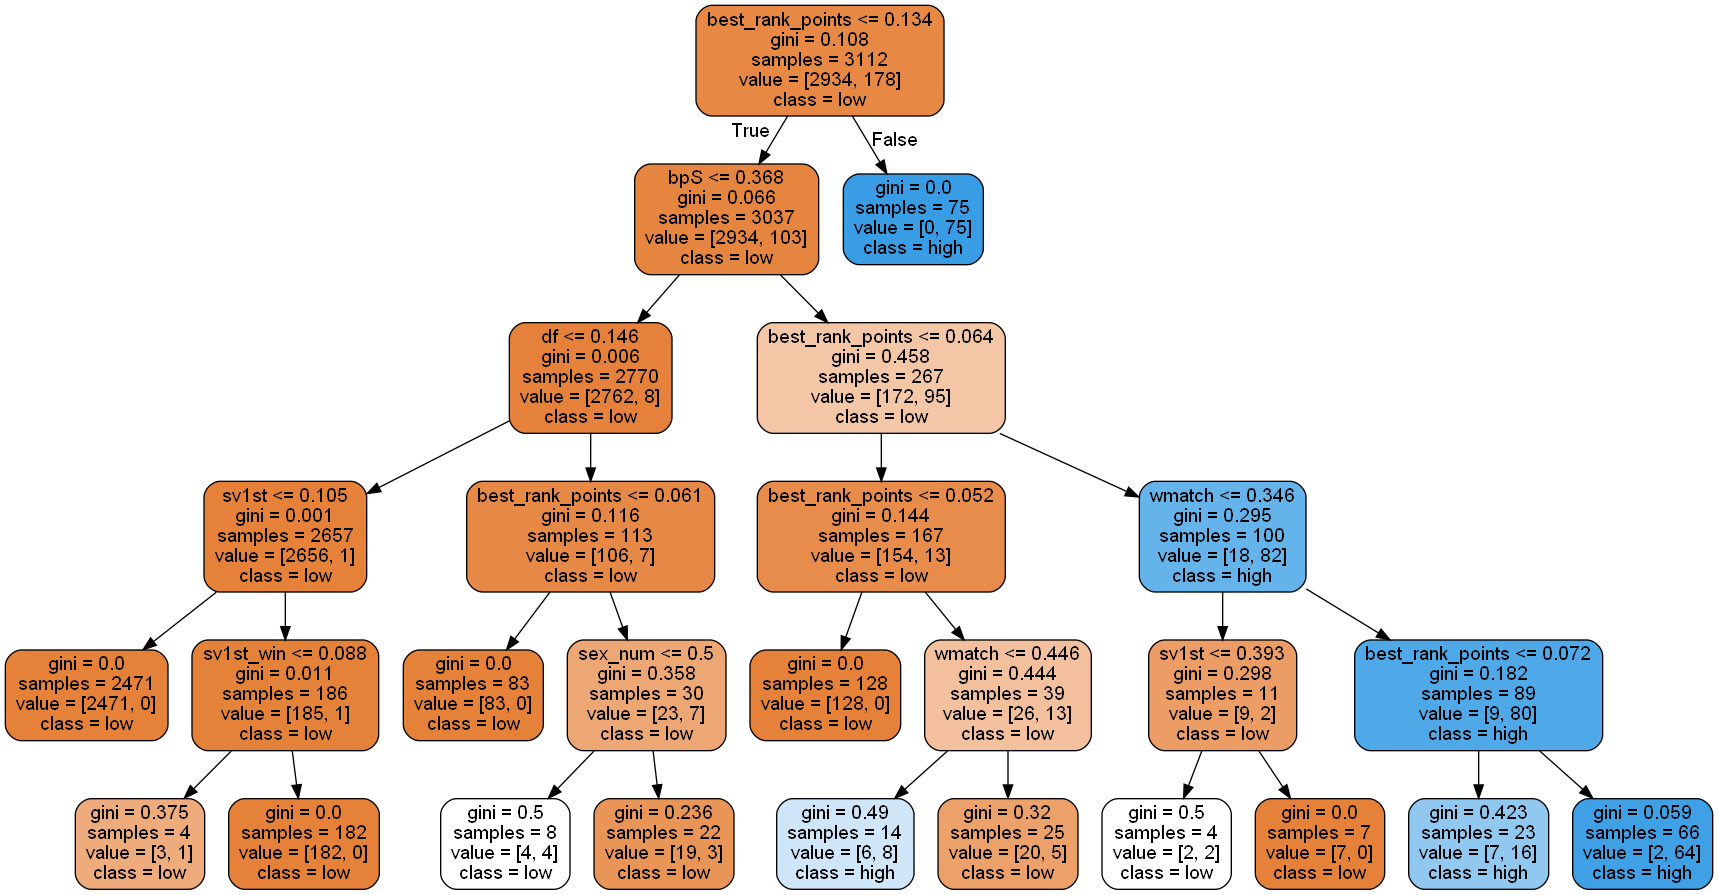

In [31]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=['low', 'high'],  #[0, 1]
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [32]:
train_pred_dt = dt.predict(train_set)
test_pred_dt = dt.predict(test_set)

#### evaluation

In [33]:
dt.predict_proba(train_set)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [34]:
#evaulate the accuracy on the train set and the test set
#metrics also contains precision, recall, f1 and the support
print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred_dt))
print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_dt))
print('Precision train set ', metrics.precision_score(train_label, train_pred_dt, average='weighted'))
print('Recall train set ', metrics.recall_score(train_label, train_pred_dt, average='weighted'))
print('F1 score train set ', metrics.f1_score(train_label, train_pred_dt, average='weighted'))
print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred_dt))

Accuracy train set  0.9903598971722365
Accuracy test set  0.90187265917603
Precision train set  0.9903598971722365
Recall train set  0.9903598971722365
F1 score train set  0.9903598971722365
Support train set  (array([0.99488753, 0.91573034]), array([0.99488753, 0.91573034]), array([0.99488753, 0.91573034]), array([2934,  178], dtype=int64))


In [35]:
#per il training set
report_scores(train_label, train_pred_dt)

              precision    recall  f1-score   support

         low       0.99      0.99      0.99      2934
        high       0.92      0.92      0.92       178

    accuracy                           0.99      3112
   macro avg       0.96      0.96      0.96      3112
weighted avg       0.99      0.99      0.99      3112



In [36]:
#per il test set
report_scores(test_label, test_pred_dt)
#l'accuracy è un buon indicatore, è significativa se è maggiore dell'accuracy della majority class. in caso di 
#situazione unbalance anche la precision e la recall aiutano a capire quanti errori abbiamo

              precision    recall  f1-score   support

         low       0.99      0.90      0.95      1258
        high       0.36      0.92      0.52        77

    accuracy                           0.90      1335
   macro avg       0.68      0.91      0.73      1335
weighted avg       0.96      0.90      0.92      1335



In [37]:
### cross validation

In [38]:
scores = cross_validate(dt, train_set, train_label, cv=3, return_train_score= True)
print('Fit time ', statistics.mean(scores['fit_time']))
print('Score time ', statistics.mean(scores['score_time']))
print('Test score ', statistics.mean(scores['test_score']))
print('Train score ', statistics.mean(scores['train_score']))

Fit time  0.010659058888753256
Score time  0.0021680990854899087
Test score  0.985539223428087
Train score  0.9919667096544326


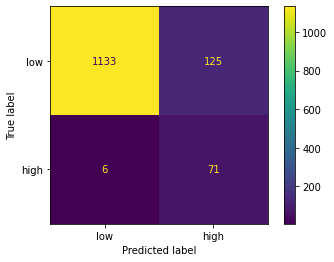

In [39]:
#plot the confusion matrix 
plot_confusion_mx(test_label, test_pred_dt)

In [40]:
#test_result = test_set
#test_result['ranked'] = test_label
#print classification for pairs of attributes/columns
#sns.pairplot(data = test_result, hue = 'ranked', palette = "Accent")

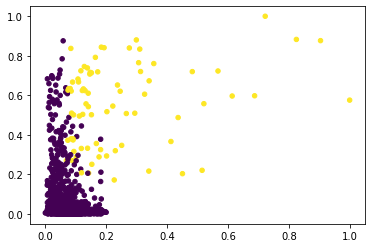

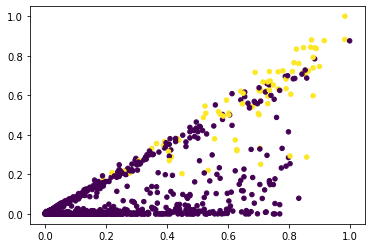

In [41]:
#true labels - different colors for different class
plt.scatter(test_set['best_rank_points'].values, test_set['sv1st'].values , c=test_label, s=20);
plt.show()
plt.scatter(test_set['nmatch'].values, test_set['sv1st'].values , c=test_label, s=20);

### SVM

In [42]:
svm_models = {}

In [43]:
svm = SVC(kernel='sigmoid', C=0.5, gamma='scale', probability=True)
svm.fit(train_set, train_label)
svm_models['svm_original'] = svm 

In [44]:
train_pred_svm = svm.predict(train_set)

In [45]:
report_scores(train_label, train_pred_svm)

              precision    recall  f1-score   support

         low       0.96      0.98      0.97      2934
        high       0.46      0.29      0.36       178

    accuracy                           0.94      3112
   macro avg       0.71      0.64      0.66      3112
weighted avg       0.93      0.94      0.93      3112



In [46]:
#prediction on the test test
test_pred_proba_svm = svm.predict_proba(test_set)
test_pred_proba_svm

array([[0.95985595, 0.04014405],
       [0.89922019, 0.10077981],
       [0.93665817, 0.06334183],
       ...,
       [0.99810453, 0.00189547],
       [0.88892922, 0.11107078],
       [0.91212916, 0.08787084]])

In [47]:
test_pred_svm = svm.predict(test_set)

In [48]:
#compute the performance of the model
report_scores(test_label, test_pred_svm)

              precision    recall  f1-score   support

         low       0.95      0.98      0.96      1258
        high       0.34      0.18      0.24        77

    accuracy                           0.93      1335
   macro avg       0.65      0.58      0.60      1335
weighted avg       0.92      0.93      0.92      1335



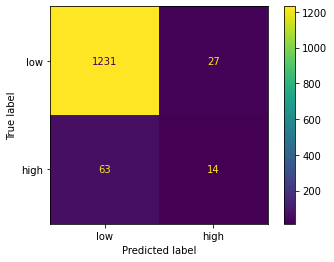

In [49]:
plot_confusion_mx(test_label, test_pred_svm)

### Rule based

In [50]:
rb_models = {}

In [51]:
#we run a grid search to find the best configuration of parameters' values
ripper = lw.RIPPER()
param_grid = {"prune_size": [0.5, 0.6], "k": [1, 3, 5]}
grid_search = GridSearchCV(estimator=ripper, param_grid=param_grid)
grid_search.fit(train_set, train_label, pos_class=1)

GridSearchCV(estimator=<RIPPER(verbosity=0, n_discretize_bins=10, random_state=None, prune_size=0.33, max_rules=None, max_rule_conds=None, dl_allowance=64, k=2, max_total_conds=None)>,
             param_grid={'k': [1, 3, 5], 'prune_size': [0.5, 0.6]})

In [52]:
print('Best parameters setting ', grid_search.cv_results_['params'][0])

Best parameters setting  {'k': 1, 'prune_size': 0.5}


In [53]:
#define and fit the rule-based model
#this function requires only one dataset with the labels. 
#To do so, we concatenate the train_set and the train_label
ripper = lw.RIPPER(k=1, prune_size=0.50)
datas = pd.concat([train_set, train_label], axis=1)
ripper.fit(datas, class_feat='ranked', pos_class=1)

In [54]:
#in this case the model is a set of rules
ripper.out_model()

[[bpS=>0.4 ^ best_rank_points=>0.1 ^ tot_minutes=>0.5] V
[sv1st_win=>0.32 ^ sex_num=0 ^ tot_minutes=0.33-0.5] V
[sv2nd_win=>0.34 ^ sex_num=0 ^ lmatch=0.4-0.57] V
[sv1st=>0.35 ^ w_tourney=>0.11 ^ sex_num=0 ^ sv1st_win=>0.32 ^ hand_num=1] V
[sv1st=>0.35 ^ best_rank_points=0.083-0.1 ^ tot_minutes=>0.5] V
[sv1st_win=>0.32 ^ w_tourney=>0.11 ^ best_rank_points=0.067-0.072] V
[df=>0.24 ^ sex_num=0 ^ best_rank_points=>0.1] V
[ace=>0.084 ^ best_rank_points=>0.1 ^ bpS=0.13-0.4] V
[sv2nd_win=>0.34 ^ best_rank_points=0.067-0.072] V
[bpS=>0.4 ^ best_rank_points=0.074-0.083] V
[df=>0.24 ^ best_rank_points=0.072-0.074 ^ w_tourney=>0.11] V
[ace=>0.084 ^ best_rank_points=0.054-0.062 ^ wmatch=0.28-0.44] V
[sv2nd_win=0.11-0.34 ^ best_rank_points=>0.1 ^ sex_num=0] V
[df=>0.24 ^ best_rank_points=0.067-0.072]]


In [55]:
rb_models['rb_original'] = ripper

In [56]:
ripper_pred_train = ripper.predict(train_set)
report_scores(train_label, ripper_pred_train)

              precision    recall  f1-score   support

         low       0.97      1.00      0.98      2934
        high       0.90      0.56      0.69       178

    accuracy                           0.97      3112
   macro avg       0.94      0.78      0.84      3112
weighted avg       0.97      0.97      0.97      3112



In [57]:
ripper_pred = ripper.predict(test_set)
report_scores(test_label, ripper_pred)

              precision    recall  f1-score   support

         low       0.97      0.99      0.98      1258
        high       0.74      0.51      0.60        77

    accuracy                           0.96      1335
   macro avg       0.85      0.75      0.79      1335
weighted avg       0.96      0.96      0.96      1335



In [58]:
#evaluation of the performance of the classifier
print('Accuracy ', ripper.score(test_set, test_label))
print('Precision ', ripper.score(test_set, test_label, precision_score))
print('Recall ', ripper.score(test_set, test_label, recall_score))

Accuracy  0.9610486891385768
Precision  0.7358490566037735
Recall  0.5064935064935064


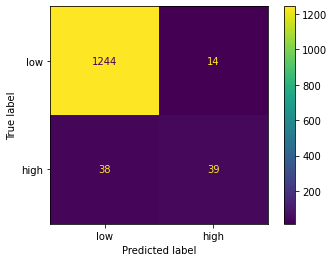

In [59]:
plot_confusion_mx(test_label, ripper_pred)

In [60]:
ripper_pred_reasons = ripper.predict(test_set, give_reasons=True)

In [61]:
indexes = [i for i,elem in enumerate(ripper_pred_reasons[0]) if elem == True]
rules_used = [ripper_pred_reasons[1][elem] for i,elem in enumerate(indexes)]

In [62]:
rules_used

[[<Rule [bpS=>0.4^best_rank_points=>0.1^tot_minutes=>0.5]>,
  <Rule [sv2nd_win=>0.34^sex_num=0^lmatch=0.4-0.57]>,
  <Rule [df=>0.24^sex_num=0^best_rank_points=>0.1]>],
 [<Rule [bpS=>0.4^best_rank_points=>0.1^tot_minutes=>0.5]>,
  <Rule [df=>0.24^sex_num=0^best_rank_points=>0.1]>],
 [<Rule [sv1st=>0.35^w_tourney=>0.11^sex_num=0^sv1st_win=>0.32^hand_num=1]>,
  <Rule [sv1st=>0.35^best_rank_points=0.083-0.1^tot_minutes=>0.5]>],
 [<Rule [ace=>0.084^best_rank_points=>0.1^bpS=0.13-0.4]>],
 [<Rule [sv1st=>0.35^best_rank_points=0.083-0.1^tot_minutes=>0.5]>],
 [<Rule [bpS=>0.4^best_rank_points=>0.1^tot_minutes=>0.5]>,
  <Rule [df=>0.24^sex_num=0^best_rank_points=>0.1]>],
 [<Rule [bpS=>0.4^best_rank_points=0.074-0.083]>],
 [<Rule [sv2nd_win=0.11-0.34^best_rank_points=>0.1^sex_num=0]>],
 [<Rule [df=>0.24^sex_num=0^best_rank_points=>0.1]>,
  <Rule [ace=>0.084^best_rank_points=>0.1^bpS=0.13-0.4]>,
  <Rule [sv2nd_win=0.11-0.34^best_rank_points=>0.1^sex_num=0]>],
 [<Rule [ace=>0.084^best_rank_points=0

### Gaussian Naive Bayes

**Importing libraries**

In [63]:
from sklearn.naive_bayes import GaussianNB

In [64]:
gnb_models = {}

**Define the model**

In [65]:
gnb_model = GaussianNB()

**Train the Gaussain Naive Bayes classifier**

In [66]:
gnb_model.fit(train_set, train_label)
gnb_models['GNB_original'] = gnb_model

In [67]:
test_pred = gnb_model.predict(test_set)
print(classification_report(test_label, test_pred, target_names = ['low','high']))

              precision    recall  f1-score   support

         low       1.00      0.92      0.96      1258
        high       0.42      0.94      0.58        77

    accuracy                           0.92      1335
   macro avg       0.71      0.93      0.77      1335
weighted avg       0.96      0.92      0.93      1335



The performance report reveals the low capacity of the GNB classifier to correctly classify the hig rank players. This is due to the highly imbalanced dataset.

Let's plot the confusion matrix

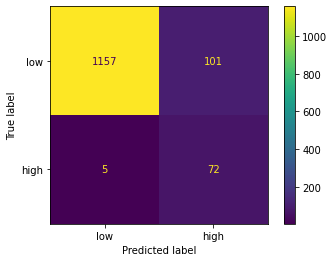

In [68]:
plot_confusion_mx(test_label, test_pred)

### AdaBoost

In [69]:
X_train, X_test, y_train, y_test = train_set.values, test_set.values, train_label.values, test_label.values

In [70]:
# Using DecisionTreeClassifier (default) as Base Learners

# Create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=50,learning_rate=1)
# Train Adaboost Classifer
model = abc.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = model.predict(X_test)

In [71]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9011235955056179


In [72]:
report_scores(test_label, y_pred)

              precision    recall  f1-score   support

         low       1.00      0.90      0.94      1258
        high       0.36      0.95      0.53        77

    accuracy                           0.90      1335
   macro avg       0.68      0.92      0.73      1335
weighted avg       0.96      0.90      0.92      1335



In [73]:
#Predict the response for train dataset
X_pred = model.predict(X_train)

In [74]:
report_scores(train_label, X_pred)

              precision    recall  f1-score   support

         low       1.00      1.00      1.00      2934
        high       0.97      0.97      0.97       178

    accuracy                           1.00      3112
   macro avg       0.98      0.98      0.98      3112
weighted avg       1.00      1.00      1.00      3112



In [75]:
# Using Support Vector Classifier as Base Learners
svc=SVC(probability=True, kernel='linear')

# Create adaboost classifer object
abc =AdaBoostClassifier(n_estimators=50, base_estimator=svc,learning_rate=1)

# Train Adaboost Classifer
model = abc.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = model.predict(X_test)


# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9423220973782771


In [76]:
report_scores(test_label, y_pred)

              precision    recall  f1-score   support

         low       0.94      1.00      0.97      1258
        high       0.00      0.00      0.00        77

    accuracy                           0.94      1335
   macro avg       0.47      0.50      0.49      1335
weighted avg       0.89      0.94      0.91      1335



c:\users\nunzi\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\nunzi\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\nunzi\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [77]:
#Predict the response for train dataset
X_pred = model.predict(X_train)

In [78]:
report_scores(train_label, X_pred)

              precision    recall  f1-score   support

         low       0.94      1.00      0.97      2934
        high       0.00      0.00      0.00       178

    accuracy                           0.94      3112
   macro avg       0.47      0.50      0.49      3112
weighted avg       0.89      0.94      0.92      3112



c:\users\nunzi\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\nunzi\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\nunzi\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

### Random Forest

In [79]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators=100)
#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(train_set,train_label)
y_pred=clf.predict(test_set)

In [80]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(test_label, y_pred))

Accuracy: 0.9857677902621723


In [81]:
report_scores(test_label, y_pred)

              precision    recall  f1-score   support

         low       0.99      0.99      0.99      1258
        high       0.85      0.91      0.88        77

    accuracy                           0.99      1335
   macro avg       0.92      0.95      0.94      1335
weighted avg       0.99      0.99      0.99      1335



In [82]:
#Predict the response for train dataset
X_pred = model.predict(X_train)

In [83]:
report_scores(train_label, X_pred)

              precision    recall  f1-score   support

         low       0.94      1.00      0.97      2934
        high       0.00      0.00      0.00       178

    accuracy                           0.94      3112
   macro avg       0.47      0.50      0.49      3112
weighted avg       0.89      0.94      0.92      3112



c:\users\nunzi\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\nunzi\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\nunzi\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

### Neural Networks

**Importing libraries**

In [84]:
import tensorflow as tf

In the following list we will save all the trained Neural Network models. 

In [85]:
nn_models = {}

**Define and compile the neural network model.**

Function that returns the defalut neural network model with initial weights.

In [86]:
def base_nn_model(optimizer = 'adam', activation='relu', dropout_rate=0.15, neurons=15, loss='binary_crossentropy'): #specify parameters so that we can do grid search
    # create model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(1, len(train_set.columns))),
        tf.keras.layers.Dense(neurons, activation=activation),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(neurons, activation=activation),
        tf.keras.layers.Dropout(dropout_rate),    
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    # Compile model
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

Give a model and trainig set, this function train the neural network model.

Best: 0.973970 using {'activation': 'relu', 'batch_size': 500, 'dropout_rate': 0.2, 'epochs': 100, 'loss': 'binary_crossentropy', 'neurons': 13, 'optimizer': 'adam'}

In [87]:
def train_nn_model(model, train_set, train_label, epochs=60, batch_size=128,validation_split=0.2, verbose=False, class_weights=None):
    x_train = np.reshape(train_set.values, (len(train_set), 1, len(train_set.columns)))
    if class_weights is not None:
        history = model.fit(x_train, train_label,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=validation_split,
                    class_weight=class_weights,
                    verbose=verbose)
    else:
        history = model.fit(x_train, train_label,
                            epochs=epochs,
                            batch_size=batch_size,
                            validation_split=validation_split,
                            verbose=verbose)
    return model, history

In [88]:
nn_model = base_nn_model()
nn_model, history = train_nn_model(nn_model, norm_train_set, train_label)
nn_models['NN_original'] = nn_model

Train the model using the original and normalized dataset.

In [89]:
nn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 15)                0         
                                                                 
 dense (Dense)               (None, 15)                240       
                                                                 
 dropout (Dropout)           (None, 15)                0         
                                                                 
 dense_1 (Dense)             (None, 15)                240       
                                                                 
 dropout_1 (Dropout)         (None, 15)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 16        
                                                                 
Total params: 496
Trainable params: 496
Non-trainable pa

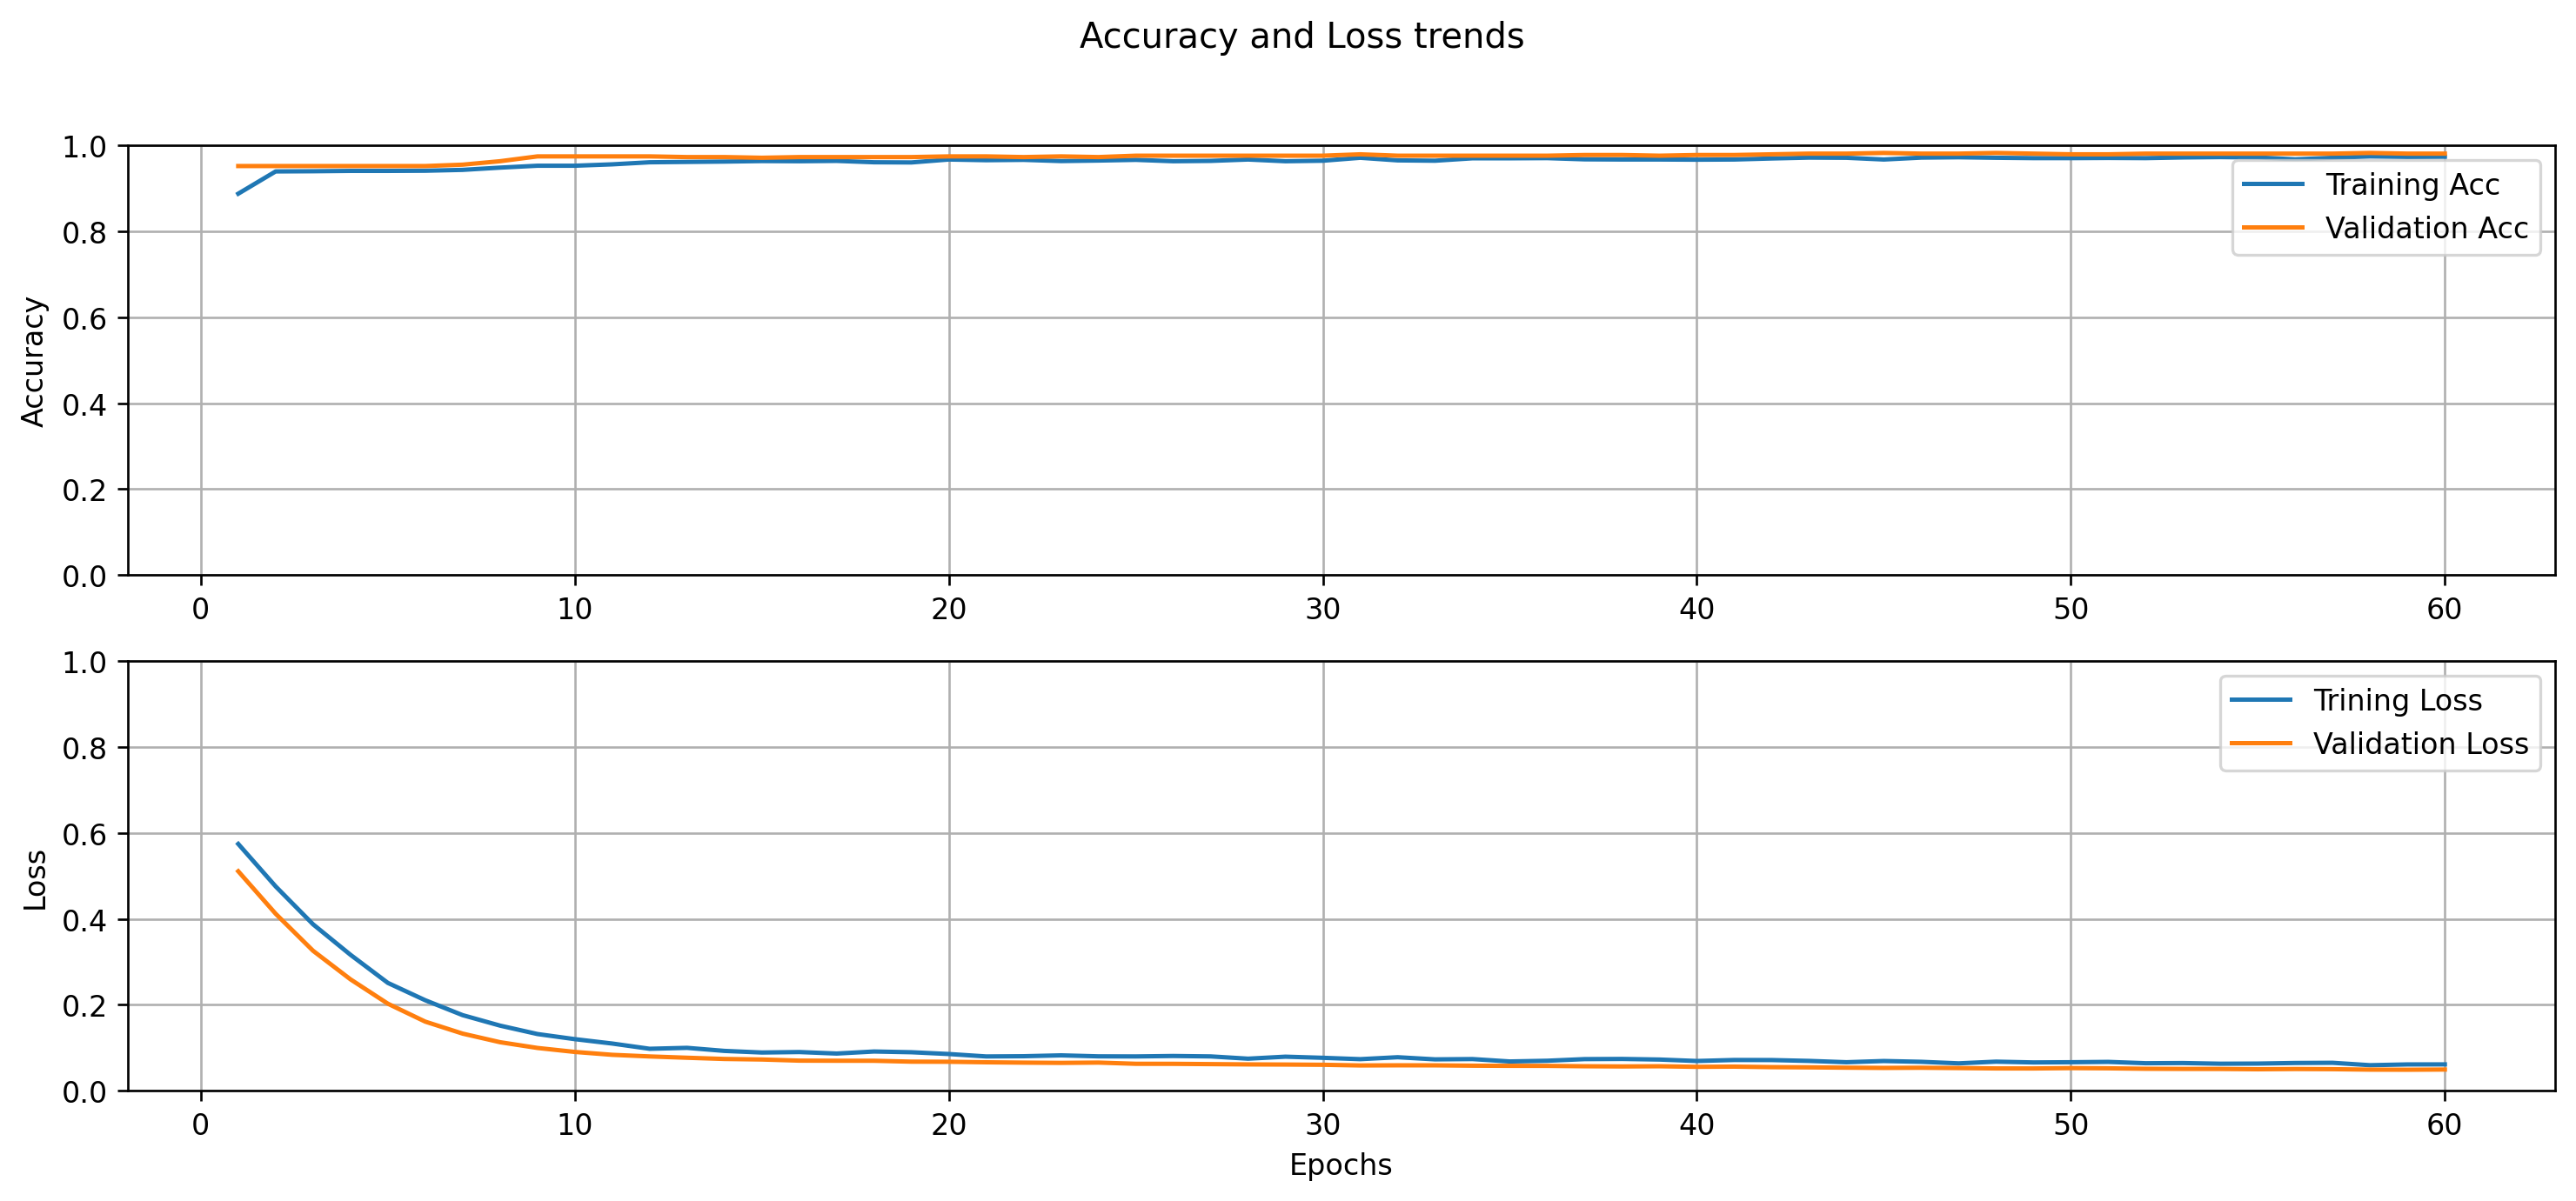

In [90]:
plot_nn_training_history(history)

In [91]:
x_train_test = np.reshape(norm_train_set.values, (len(norm_train_set), 1, len(train_set.columns)))
train_pred = (nn_model.predict(x_train_test) > 0.5).astype("int32")

In [92]:
report_scores(train_label, train_pred)

              precision    recall  f1-score   support

         low       0.99      0.99      0.99      2934
        high       0.83      0.78      0.80       178

    accuracy                           0.98      3112
   macro avg       0.91      0.89      0.90      3112
weighted avg       0.98      0.98      0.98      3112



In [93]:
x_test = np.reshape(norm_test_set.values, (len(norm_test_set), 1, len(norm_test_set.columns)))
test_pred = (nn_model.predict(x_test) > 0.5).astype("int32")

In [94]:
report_scores(test_label, test_pred)

              precision    recall  f1-score   support

         low       0.99      0.99      0.99      1258
        high       0.87      0.77      0.81        77

    accuracy                           0.98      1335
   macro avg       0.93      0.88      0.90      1335
weighted avg       0.98      0.98      0.98      1335



Given the trained NN model, let's look the cofusion matrix on the test set

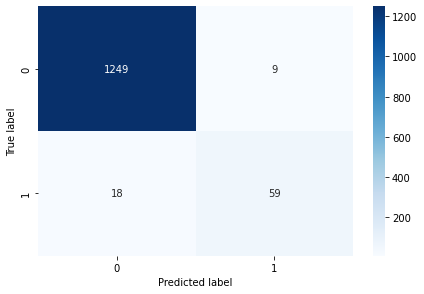

In [95]:
cm=confusion_matrix(test_label,test_pred)
#il parametro fmt serve per evitare la notazione esponenziale dei numeri
sns.heatmap(cm, annot=True,cmap=plt.cm.Blues, fmt='g')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

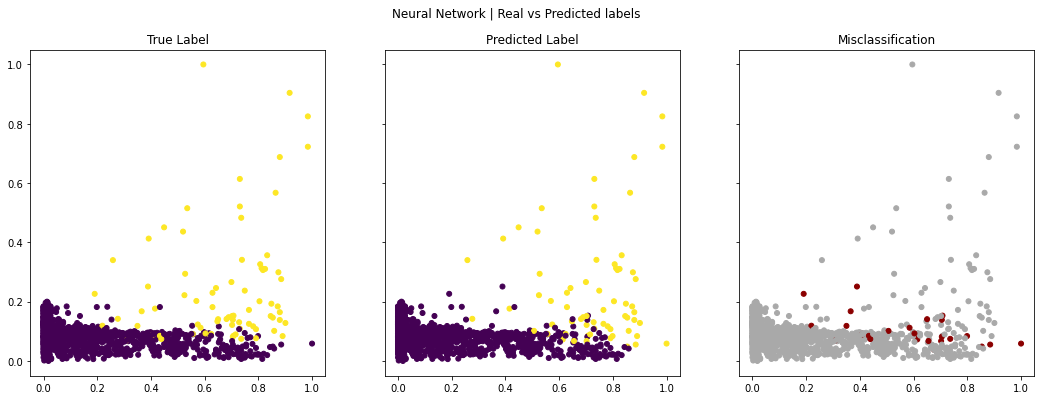

In [96]:
scatter_pred_data(norm_test_set, test_label, test_pred, 'Neural Network', 'nmatch', 'best_rank_points')

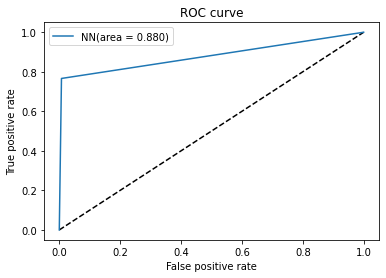

In [97]:
roc_curve_plot(nn_model, norm_test_set, test_label, test_pred, 'NN')

### KNN (K-Nearest Neighbors)

In [98]:
from sklearn.neighbors import KNeighborsClassifier

In [99]:
knn_models = {}

Fit and scoring the classifier using the function *GridSearchCV*, by sklearn, that automatically compute the best combination of parameters for the model training. Below are created the set of parameters for the KNN training that the function will use.

For the KNN we need to remove the categorical attributes.

In [100]:
knn_train_set = train_set.drop(columns=['sex_num', 'hand_num'])
knn_test_set = test_set.drop(columns=['sex_num', 'hand_num'])

In [101]:
k_range = range(1,31)

In [102]:
knn_metrics = ['euclidean', 'manhattan']

In [103]:
knn_weights = ['uniform', 'distance']

In [104]:
knn_algorithms = ['ball_tree', 'kd_tree', 'brute']

In [105]:
knn_param_grid = {
    'n_neighbors': k_range,
    'metric': knn_metrics,
    'algorithm': knn_algorithms,
    'weights': knn_weights
            }

In [106]:
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=10, scoring='accuracy')
knn_grid.fit(knn_train_set, train_label)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': range(1, 31),
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [107]:
print('Accuracy: ' + str(knn_grid.best_score_))
print('Parameters: ' + str(knn_grid.best_params_))

Accuracy: 0.9723647868744332
Parameters: {'algorithm': 'ball_tree', 'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}


In [108]:
knn = KNeighborsClassifier(**knn_grid.best_params_).fit(knn_train_set, train_label)

In [109]:
knn_models['knn_original'] = knn

In [110]:
train_pred = knn.predict(knn_train_set)
report_scores(train_label,train_pred)

              precision    recall  f1-score   support

         low       0.99      1.00      0.99      2934
        high       0.95      0.83      0.88       178

    accuracy                           0.99      3112
   macro avg       0.97      0.91      0.94      3112
weighted avg       0.99      0.99      0.99      3112



In [111]:
test_pred = knn.predict(knn_test_set)
report_scores(test_label,test_pred)

              precision    recall  f1-score   support

         low       0.98      0.98      0.98      1258
        high       0.74      0.71      0.73        77

    accuracy                           0.97      1335
   macro avg       0.86      0.85      0.86      1335
weighted avg       0.97      0.97      0.97      1335



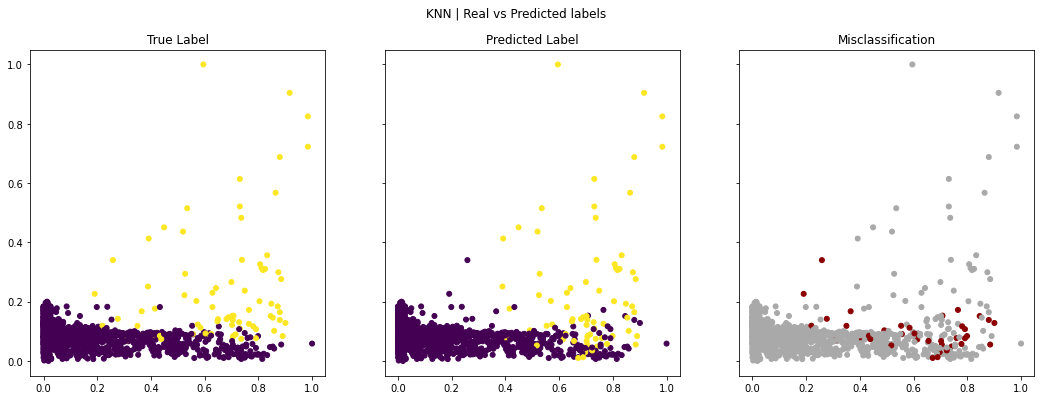

In [112]:
scatter_pred_data(test_set, test_label, test_pred, 'KNN', 'nmatch', 'best_rank_points')

As we know from the theory, the nearest neighbor classifiers can be biased by noise points that have oversized data values that can miss lead the classification task. The solution to this problem is normalization, in the following lines of code a normalized dataset is created using the *MinMaxScaler*

In [113]:
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=10, scoring='accuracy')
norm_knn_train_set = normalize_dataset(knn_train_set)
norm_knn_test_set = normalize_dataset(knn_test_set)
knn_grid.fit(norm_knn_train_set, train_label)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': range(1, 31),
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [114]:
print('Accuracy: ' + str(knn_grid.best_score_))
print('Parameters: ' + str(knn_grid.best_params_))

Accuracy: 0.9723647868744332
Parameters: {'algorithm': 'ball_tree', 'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}


In [115]:
knn = KNeighborsClassifier(**knn_grid.best_params_).fit(norm_knn_train_set, train_label)

In [116]:
train_pred = knn.predict(norm_knn_train_set)
report_scores(train_label,train_pred)

              precision    recall  f1-score   support

         low       0.99      1.00      0.99      2934
        high       0.95      0.83      0.88       178

    accuracy                           0.99      3112
   macro avg       0.97      0.91      0.94      3112
weighted avg       0.99      0.99      0.99      3112



In [117]:
test_pred = knn.predict(norm_knn_test_set)
report_scores(test_label,test_pred)

              precision    recall  f1-score   support

         low       0.98      0.98      0.98      1258
        high       0.74      0.71      0.73        77

    accuracy                           0.97      1335
   macro avg       0.86      0.85      0.86      1335
weighted avg       0.97      0.97      0.97      1335



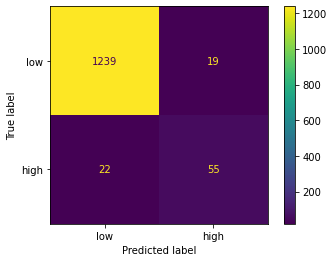

In [118]:
plot_confusion_mx(test_label, test_pred)

# Classification with weights

Weights associated with classes in the form {class_label: weight}.

The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as:

$\frac{n_{samples}}{(n_{classes}\  *\  np.bincount(y))}$

In [119]:
#set weights
weights = {0:1.0, 1:100.0} #0=low, 1 = high
balance = [{0:0.8,1:3.5}, {0:1,1:5}, {0:1,1:10}, {0:1,1:15}, {0:1,1:20}, {0:1,1:50}, {0:1,1:100}, 'balanced']

### Decision tree

In [120]:
dt = tree.DecisionTreeClassifier(criterion='gini', splitter='best', 
                                  max_depth=5, class_weight=weights,
                                  min_samples_split=3, min_samples_leaf=4)
dt = dt.fit(train_set, train_label)

#### choise of weights

In [121]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
param_grid = dict(class_weight=balance)
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')

In [122]:
grid_result = grid_search.fit(test_set, test_label)

In [123]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.965046 using {'class_weight': 'balanced'}
0.952006 (0.050788) with: {'class_weight': {0: 0.8, 1: 3.5}}
0.951711 (0.051091) with: {'class_weight': {0: 1, 1: 5}}
0.962464 (0.040818) with: {'class_weight': {0: 1, 1: 10}}
0.964861 (0.038084) with: {'class_weight': {0: 1, 1: 15}}
0.962621 (0.045236) with: {'class_weight': {0: 1, 1: 20}}
0.962073 (0.045232) with: {'class_weight': {0: 1, 1: 50}}
0.964348 (0.040809) with: {'class_weight': {0: 1, 1: 100}}
0.965046 (0.041161) with: {'class_weight': 'balanced'}


In [124]:
dt = tree.DecisionTreeClassifier(criterion='gini', splitter='best', 
                                  max_depth=5, class_weight={0: 1, 1: 50},
                                  min_samples_split=3, min_samples_leaf=4)
dt = dt.fit(train_set, train_label)
dt_models['dt_weighted'] = dt

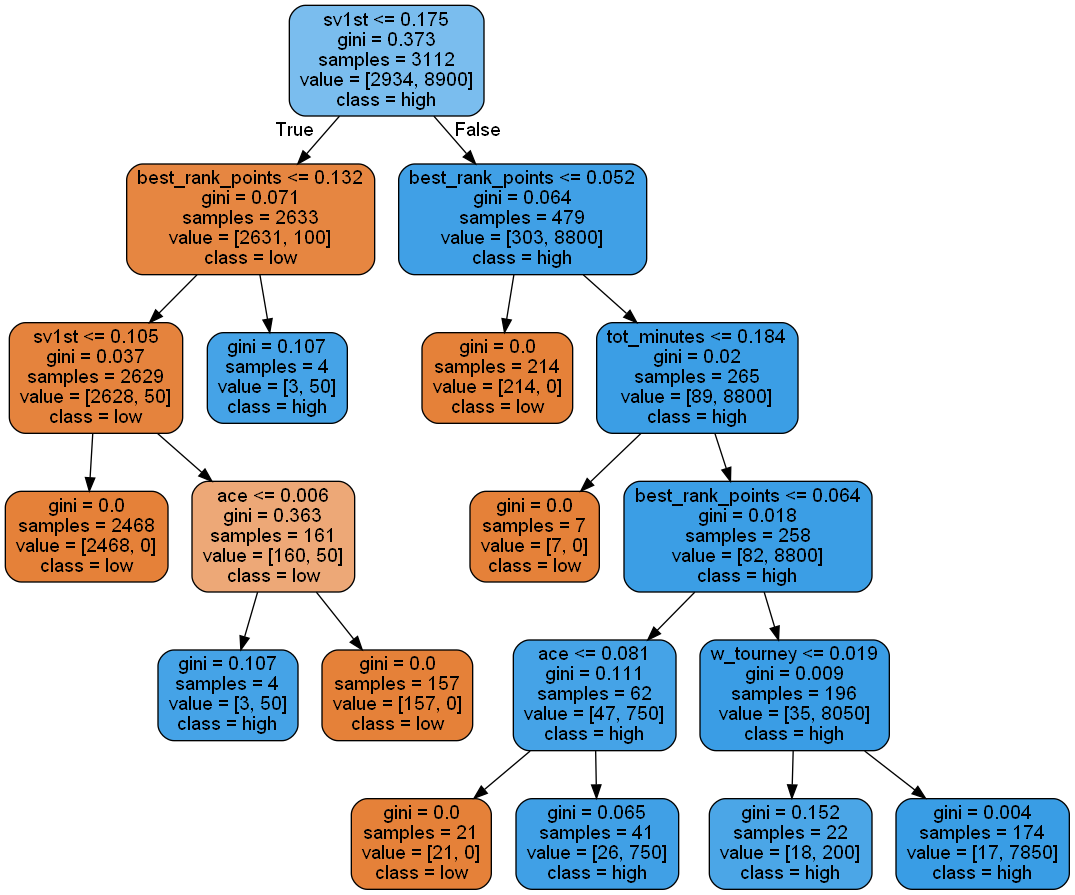

In [125]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=['low', 'high'],  #[0, 1]
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [126]:
train_pred_dt = dt.predict(train_set)
test_pred_dt = dt.predict(test_set)

In [127]:
report_scores(train_label, train_pred_dt)

              precision    recall  f1-score   support

         low       1.00      0.98      0.99      2934
        high       0.73      1.00      0.84       178

    accuracy                           0.98      3112
   macro avg       0.86      0.99      0.92      3112
weighted avg       0.98      0.98      0.98      3112



In [128]:
report_scores(test_label, test_pred_dt)

              precision    recall  f1-score   support

         low       1.00      0.87      0.93      1258
        high       0.32      0.99      0.48        77

    accuracy                           0.88      1335
   macro avg       0.66      0.93      0.71      1335
weighted avg       0.96      0.88      0.90      1335



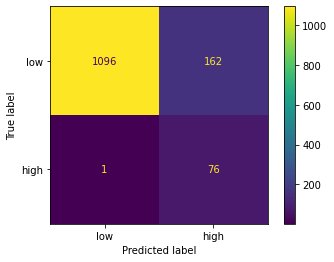

In [129]:
plot_confusion_mx(test_label, test_pred_dt)
plt.show() 

### SVM

In [130]:
svm = SVC(gamma='scale', class_weight=weights)
svm.fit(train_set, train_label)

SVC(class_weight={0: 1.0, 1: 100.0})

In [131]:
train_pred = svm.predict(train_set)
report_scores(train_label, train_pred)

              precision    recall  f1-score   support

         low       1.00      0.91      0.95      2934
        high       0.40      1.00      0.58       178

    accuracy                           0.92      3112
   macro avg       0.70      0.96      0.76      3112
weighted avg       0.97      0.92      0.93      3112



In [132]:
test_pred = svm.predict(test_set)

In [133]:
#compute the performance of the model
report_scores(test_label, test_pred)

              precision    recall  f1-score   support

         low       1.00      0.91      0.95      1258
        high       0.40      0.99      0.57        77

    accuracy                           0.91      1335
   macro avg       0.70      0.95      0.76      1335
weighted avg       0.96      0.91      0.93      1335



#### choise of weights

In [134]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
param_grid = dict(class_weight=balance)
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')

In [135]:
grid_result = grid_search.fit(test_set, test_label)

In [136]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.992114 using {'class_weight': {0: 1, 1: 20}}
0.990943 (0.008483) with: {'class_weight': {0: 0.8, 1: 3.5}}
0.991756 (0.008295) with: {'class_weight': {0: 1, 1: 5}}
0.990431 (0.008654) with: {'class_weight': {0: 1, 1: 10}}
0.991841 (0.008248) with: {'class_weight': {0: 1, 1: 15}}
0.992114 (0.007963) with: {'class_weight': {0: 1, 1: 20}}
0.990699 (0.008462) with: {'class_weight': {0: 1, 1: 50}}
0.990699 (0.008462) with: {'class_weight': {0: 1, 1: 100}}
0.989191 (0.009238) with: {'class_weight': 'balanced'}


In [137]:
svm = SVC(gamma='scale', class_weight={0: 1, 1: 10})
svm.fit(train_set, train_label)
svm_models['svm_weighted'] = svm

In [138]:
test_pred = svm.predict(test_set)
report_scores(test_label, test_pred)

              precision    recall  f1-score   support

         low       1.00      0.95      0.97      1258
        high       0.56      0.97      0.71        77

    accuracy                           0.95      1335
   macro avg       0.78      0.96      0.84      1335
weighted avg       0.97      0.95      0.96      1335



In [139]:
train_pred = svm.predict(train_set)
report_scores(train_label, train_pred)

              precision    recall  f1-score   support

         low       1.00      0.95      0.97      2934
        high       0.54      0.98      0.69       178

    accuracy                           0.95      3112
   macro avg       0.77      0.96      0.83      3112
weighted avg       0.97      0.95      0.96      3112



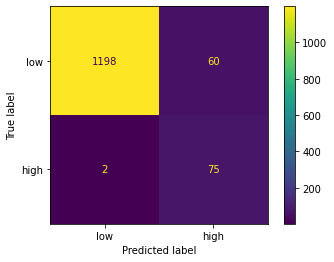

In [140]:
plot_confusion_mx(test_label, test_pred)

### Rule based

In [141]:
#we run a grid search to find the best configuration of parameters' values
ripper = lw.RIPPER()
param_grid = {"prune_size": [0.5, 0.6], "k": [1, 3, 5], "class_weight": balance}
grid_search = GridSearchCV(estimator=ripper, param_grid=param_grid)
grid_search.fit(train_set, train_label, pos_class=1)

GridSearchCV(estimator=<RIPPER(verbosity=0, n_discretize_bins=10, random_state=None, prune_size=0.33, max_rules=None, max_rule_conds=None, dl_allowance=64, k=2, max_total_conds=None)>,
             param_grid={'class_weight': [{0: 0.8, 1: 3.5}, {0: 1, 1: 5},
                                          {0: 1, 1: 10}, {0: 1, 1: 15},
                                          {0: 1, 1: 20}, {0: 1, 1: 50},
                                          {0: 1, 1: 100}, 'balanced'],
                         'k': [1, 3, 5], 'prune_size': [0.5, 0.6]})

In [142]:
print('Best parameters setting ', grid_search.cv_results_['params'][0])

Best parameters setting  {'class_weight': {0: 0.8, 1: 3.5}, 'k': 1, 'prune_size': 0.5}


In [143]:
ripper = lw.RIPPER(k=1, prune_size=0.50)
datas = pd.concat([train_set, train_label], axis=1)
ripper.fit(datas, class_feat='ranked', pos_class=1, class_weight = {0: 1, 1: 100})

In [144]:
#in this case the model is a set of rules
ripper.out_model()

[[bpS=>0.4 ^ best_rank_points=>0.1 ^ wmatch=>0.44] V
[bpS=>0.4 ^ sex_num=0 ^ df=>0.24 ^ ace=>0.084] V
[sv1st=>0.35 ^ best_rank_points=>0.1] V
[bpS=>0.4 ^ best_rank_points=0.083-0.1] V
[df=>0.24 ^ sex_num=0 ^ best_rank_points=>0.1] V
[sv1st_win=>0.32 ^ sex_num=0 ^ w_tourney=>0.11] V
[sv1st_win=>0.32 ^ best_rank_points=0.072-0.074] V
[df=>0.24 ^ best_rank_points=0.067-0.072] V
[bpS=>0.4 ^ best_rank_points=0.054-0.062 ^ wmatch=0.28-0.44] V
[ace=0.023-0.084 ^ sex_num=0 ^ best_rank_points=>0.1] V
[ace=>0.084 ^ best_rank_points=0.062-0.067] V
[sv2nd_win=0.11-0.34 ^ sex_num=0 ^ nmatch=0.24-0.4 ^ best_rank_points=>0.1] V
[bpS=>0.4 ^ best_rank_points=0.074-0.083] V
[sv1st=>0.35 ^ best_rank_points=0.067-0.072]]


In [145]:
rb_models['rb_weighted'] = ripper

In [146]:
ripper_pred_train = ripper.predict(train_set)
report_scores(train_label, ripper_pred_train)

              precision    recall  f1-score   support

         low       0.98      0.99      0.98      2934
        high       0.82      0.61      0.70       178

    accuracy                           0.97      3112
   macro avg       0.90      0.80      0.84      3112
weighted avg       0.97      0.97      0.97      3112



In [147]:
ripper_pred = ripper.predict(test_set)
report_scores(test_label, ripper_pred)

              precision    recall  f1-score   support

         low       0.97      0.98      0.98      1258
        high       0.63      0.48      0.54        77

    accuracy                           0.95      1335
   macro avg       0.80      0.73      0.76      1335
weighted avg       0.95      0.95      0.95      1335



In [148]:
#evaluation of the performance of the classifier
print('Accuracy ', ripper.score(test_set, test_label))
print('Precision ', ripper.score(test_set, test_label, precision_score))
print('Recall ', ripper.score(test_set, test_label, recall_score))

Accuracy  0.9535580524344569
Precision  0.6271186440677966
Recall  0.4805194805194805


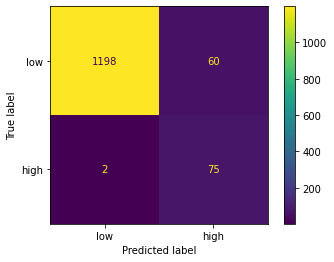

In [149]:
plot_confusion_mx(test_label, test_pred)

In [150]:
ripper_pred_reasons = ripper.predict(test_set, give_reasons=True)

In [151]:
indexes = [i for i,elem in enumerate(ripper_pred_reasons[0]) if elem == True]
rules_used = [ripper_pred_reasons[1][elem] for i,elem in enumerate(indexes)]
rules_used

[[<Rule [bpS=>0.4^best_rank_points=>0.1^wmatch=>0.44]>,
  <Rule [bpS=>0.4^sex_num=0^df=>0.24^ace=>0.084]>,
  <Rule [sv1st=>0.35^best_rank_points=>0.1]>,
  <Rule [df=>0.24^sex_num=0^best_rank_points=>0.1]>,
  <Rule [sv1st_win=>0.32^sex_num=0^w_tourney=>0.11]>],
 [<Rule [bpS=>0.4^best_rank_points=>0.1^wmatch=>0.44]>,
  <Rule [bpS=>0.4^sex_num=0^df=>0.24^ace=>0.084]>,
  <Rule [sv1st=>0.35^best_rank_points=>0.1]>,
  <Rule [df=>0.24^sex_num=0^best_rank_points=>0.1]>],
 [<Rule [bpS=>0.4^sex_num=0^df=>0.24^ace=>0.084]>,
  <Rule [bpS=>0.4^best_rank_points=0.083-0.1]>,
  <Rule [sv1st_win=>0.32^sex_num=0^w_tourney=>0.11]>],
 [<Rule [bpS=>0.4^best_rank_points=0.083-0.1]>],
 [<Rule [bpS=>0.4^best_rank_points=>0.1^wmatch=>0.44]>,
  <Rule [bpS=>0.4^sex_num=0^df=>0.24^ace=>0.084]>,
  <Rule [sv1st=>0.35^best_rank_points=>0.1]>,
  <Rule [df=>0.24^sex_num=0^best_rank_points=>0.1]>],
 [<Rule [bpS=>0.4^best_rank_points=0.074-0.083]>],
 [<Rule [ace=0.023-0.084^sex_num=0^best_rank_points=>0.1]>],
 [<Rule [d

### Neural Networks

Now let's re-run the neural network classifier using the weighted classes.

#### choise of weights

In [152]:
from sklearn.utils import class_weight
weights_nn = {0: 0.75, 1: 3.5}
class_weights = class_weight.compute_class_weight(class_weight = weights_nn,
                                                 classes = np.unique(train_label),
                                                 y = train_label)
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 0.75, 1: 3.5}


In [153]:
nn_model_w = base_nn_model()
nn_model_w, history = train_nn_model(nn_model_w, norm_train_set, train_label)
nn_models['NN_weighted'] = nn_model_w

Train the model using the original and normalized dataset.

In [154]:
nn_model_w.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 15)                0         
                                                                 
 dense_3 (Dense)             (None, 15)                240       
                                                                 
 dropout_2 (Dropout)         (None, 15)                0         
                                                                 
 dense_4 (Dense)             (None, 15)                240       
                                                                 
 dropout_3 (Dropout)         (None, 15)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 16        
                                                                 
Total params: 496
Trainable params: 496
Non-trainable 

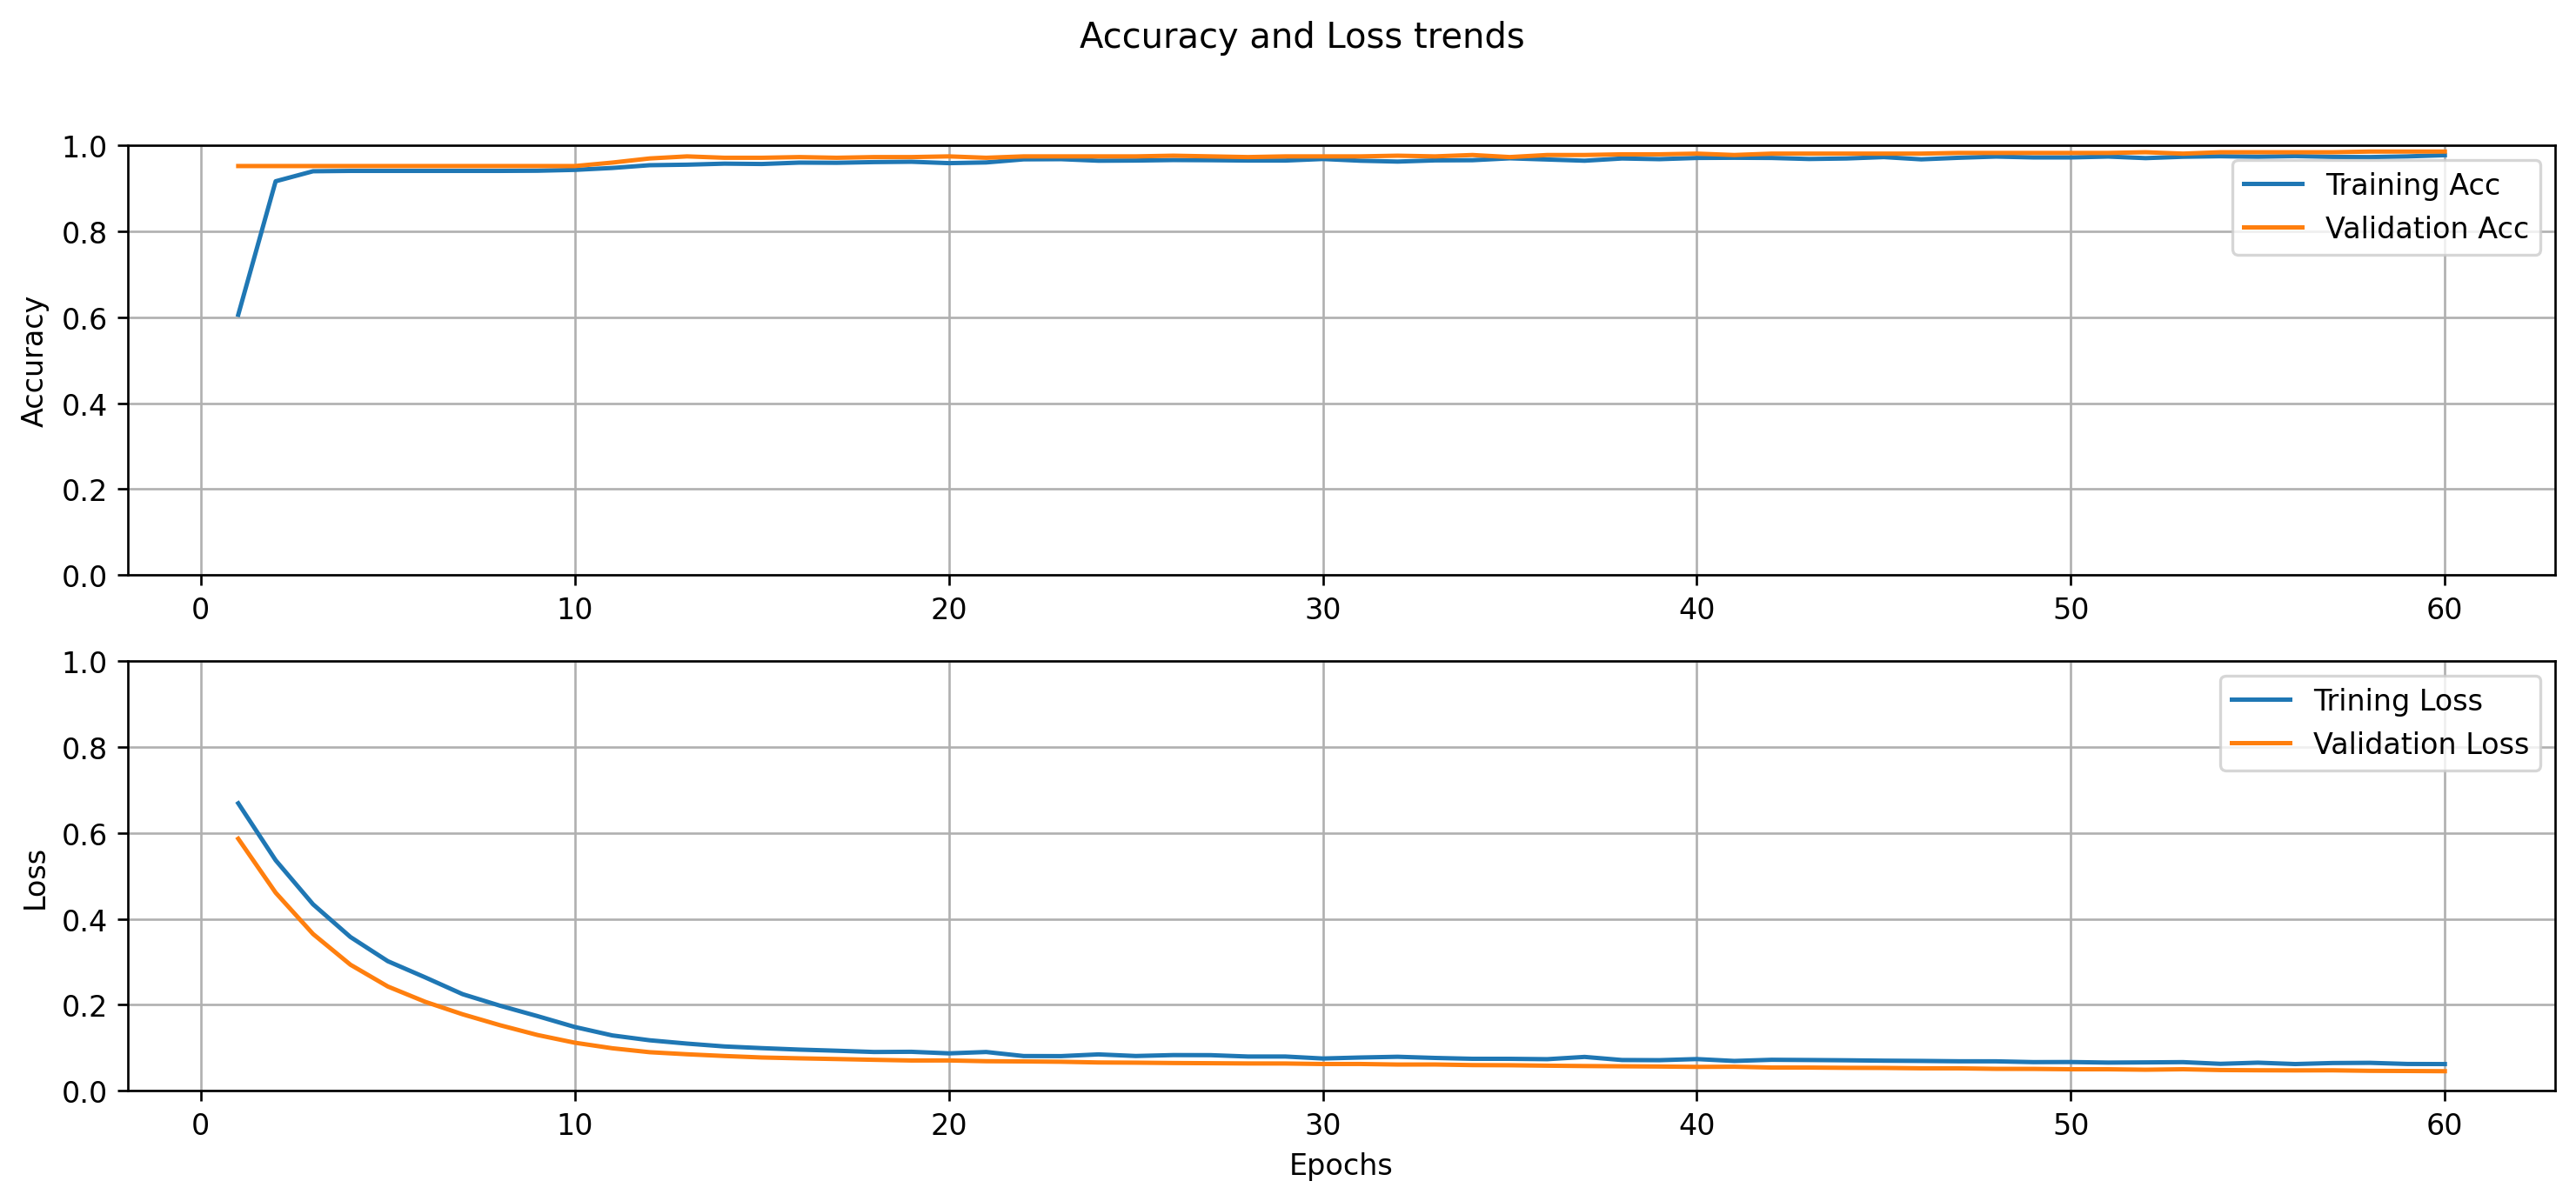

In [155]:
plot_nn_training_history(history)

In [156]:
x_train_test = np.reshape(norm_train_set.values, (len(norm_train_set), 1, len(norm_train_set.columns)))
train_pred = (nn_model_w.predict(x_train_test) > 0.5).astype("int32")

In [157]:
report_scores(train_label, train_pred)

              precision    recall  f1-score   support

         low       0.99      0.99      0.99      2934
        high       0.85      0.79      0.82       178

    accuracy                           0.98      3112
   macro avg       0.92      0.89      0.90      3112
weighted avg       0.98      0.98      0.98      3112



In [158]:
x_test = np.reshape(norm_test_set.values, (len(norm_test_set), 1, len(norm_test_set.columns)))
test_pred = (nn_model_w.predict(x_test) > 0.5).astype("int32")

In [159]:
report_scores(test_label, test_pred)

              precision    recall  f1-score   support

         low       0.99      0.99      0.99      1258
        high       0.86      0.78      0.82        77

    accuracy                           0.98      1335
   macro avg       0.92      0.89      0.90      1335
weighted avg       0.98      0.98      0.98      1335



Given the trained NN model, let's look the cofusion matrix on the test set

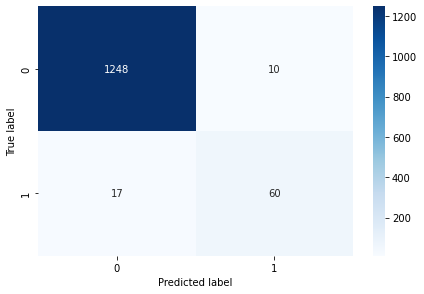

In [160]:
cm=confusion_matrix(test_label,test_pred)
#il parametro fmt serve per evitare la notazione esponenziale dei numeri
sns.heatmap(cm, annot=True,cmap=plt.cm.Blues, fmt='g')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

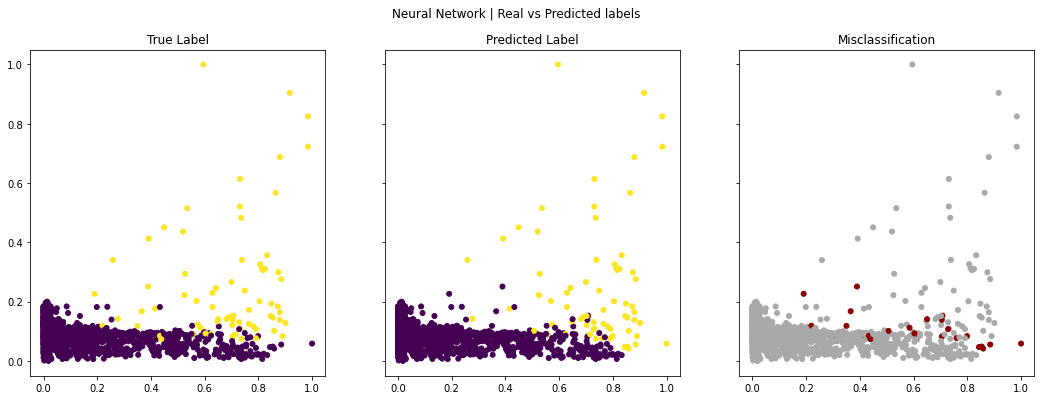

In [161]:
scatter_pred_data(norm_test_set, test_label, test_pred, 'Neural Network', 'nmatch', 'best_rank_points')

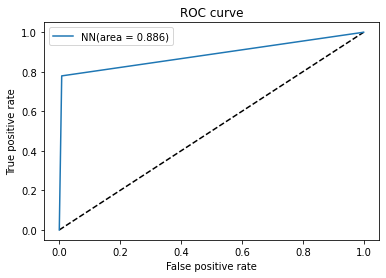

In [162]:
roc_curve_plot(nn_model_w, norm_test_set, test_label, test_pred, 'NN')

# Oversampling with SMOTE

In [163]:
oversample = SMOTE(sampling_strategy=0.3)
training, labels = oversample.fit_resample(train_set, train_label)

**Original Dataset**

In [164]:
print_dataset_composition(train_set, train_label, test_set, test_label)

3112 training samples:
	- 2934 samples for the class Low Rank
	- 178 samples for the class High Rank

1335 test samples:
	- 1258 samples for the class Low Rank
	- 77 samples for the class High Rank


**Dataset after oversampling**

In [165]:
print_dataset_composition(training, labels, test_set, test_label)

3814 training samples:
	- 2934 samples for the class Low Rank
	- 880 samples for the class High Rank

1335 test samples:
	- 1258 samples for the class Low Rank
	- 77 samples for the class High Rank


### Decision tree

In [166]:
dt = tree.DecisionTreeClassifier(criterion='gini', splitter='best', 
                                  max_depth=5, 
                                  min_samples_split=3, min_samples_leaf=4)
dt = dt.fit(training, labels)
dt_models['dt_ov'] = dt

In [167]:
train_pred = dt.predict(train_set)
report_scores(train_label, train_pred)

              precision    recall  f1-score   support

         low       1.00      0.99      1.00      2934
        high       0.89      0.97      0.93       178

    accuracy                           0.99      3112
   macro avg       0.94      0.98      0.96      3112
weighted avg       0.99      0.99      0.99      3112



In [168]:
test_pred_dt = dt.predict(test_set)

In [169]:
report_scores(test_label, test_pred_dt)

              precision    recall  f1-score   support

         low       1.00      0.90      0.95      1258
        high       0.38      0.97      0.54        77

    accuracy                           0.91      1335
   macro avg       0.69      0.94      0.75      1335
weighted avg       0.96      0.91      0.92      1335



### SVM

In [170]:
svm = SVC(kernel='sigmoid', gamma='scale')
svm.fit(training, labels)
svm_models['svm_ov'] = svm 

In [171]:
train_pred = svm.predict(train_set)
report_scores(train_label, train_pred)

              precision    recall  f1-score   support

         low       0.99      0.93      0.96      2934
        high       0.39      0.78      0.52       178

    accuracy                           0.92      3112
   macro avg       0.69      0.85      0.74      3112
weighted avg       0.95      0.92      0.93      3112



In [172]:
test_pred = svm.predict(test_set)

In [173]:
report_scores(test_label, test_pred)

              precision    recall  f1-score   support

         low       0.98      0.93      0.96      1258
        high       0.40      0.73      0.52        77

    accuracy                           0.92      1335
   macro avg       0.69      0.83      0.74      1335
weighted avg       0.95      0.92      0.93      1335



### Rule based

In [174]:
#we run a grid search to find the best configuration of parameters' values
ripper = lw.RIPPER()
param_grid = {"prune_size": [0.5, 0.6], "k": [1, 3, 5]}
grid_search = GridSearchCV(estimator=ripper, param_grid=param_grid)
grid_search.fit(training, labels, pos_class=1)

GridSearchCV(estimator=<RIPPER(verbosity=0, n_discretize_bins=10, random_state=None, prune_size=0.33, max_rules=None, max_rule_conds=None, dl_allowance=64, k=2, max_total_conds=None)>,
             param_grid={'k': [1, 3, 5], 'prune_size': [0.5, 0.6]})

In [175]:
print('Best parameters setting ', grid_search.cv_results_['params'][0])

Best parameters setting  {'k': 1, 'prune_size': 0.5}


In [176]:
ripper = lw.RIPPER(k=1, prune_size=0.50)
datas = pd.concat([training, labels], axis=1)
ripper.fit(datas, class_feat='ranked', pos_class=1)

In [177]:
#in this case the model is a set of rules
ripper.out_model()

[[best_rank_points=>0.13 ^ sex_num=0] V
[sv2nd_win=>0.61 ^ w_tourney=>0.19 ^ sv1st_win=>0.59 ^ ace=>0.19] V
[sv2nd_win=>0.61 ^ lmatch=0.56-0.67 ^ tot_minutes=>0.66] V
[sv1st=0.44-0.64 ^ sex_num=0 ^ sv2nd_win=0.4-0.61] V
[sv1st=0.44-0.64 ^ sex_num=0] V
[sv1st_win=>0.59 ^ best_rank_points=0.1-0.13] V
[sv2nd_win=>0.61 ^ best_rank_points=0.084-0.1] V
[sv2nd_win=0.4-0.61 ^ sex_num=0] V
[ace=>0.19 ^ best_rank_points=>0.13] V
[ace=0.092-0.19 ^ nmatch=>0.71 ^ w_tourney=>0.19] V
[df=>0.4 ^ wmatch=0.44-0.54 ^ ace=>0.19] V
[sv1st=0.19-0.44 ^ sex_num=0 ^ best_rank_points=0.1-0.13] V
[ace=0.092-0.19 ^ best_rank_points=0.059-0.066] V
[bpS=0.49-0.66 ^ w_tourney=0.074-0.11] V
[ace=0.092-0.19 ^ w_tourney=0.11-0.19 ^ lmatch=0.56-0.67] V
[ace=0.092-0.19 ^ best_rank_points=0.074-0.084] V
[df=0.14-0.28 ^ best_rank_points=0.084-0.1 ^ sex_num=0] V
[bpS=0.49-0.66 ^ ace=0.041-0.092 ^ sv1st_win=0.17-0.39] V
[sv1st_win=0.39-0.59 ^ best_rank_points=0.05-0.059 ^ tot_minutes=0.38-0.53] V
[df=0.28-0.4 ^ best_rank_po

In [178]:
rb_models['rb_ov'] = ripper

In [179]:
ripper_pred_train = ripper.predict(train_set)
report_scores(train_label, ripper_pred_train)

              precision    recall  f1-score   support

         low       1.00      0.98      0.99      2934
        high       0.77      0.98      0.86       178

    accuracy                           0.98      3112
   macro avg       0.88      0.98      0.93      3112
weighted avg       0.99      0.98      0.98      3112



In [180]:
ripper_pred = ripper.predict(test_set)
report_scores(test_label, ripper_pred)

              precision    recall  f1-score   support

         low       0.99      0.97      0.98      1258
        high       0.61      0.81      0.69        77

    accuracy                           0.96      1335
   macro avg       0.80      0.89      0.84      1335
weighted avg       0.97      0.96      0.96      1335



In [181]:
#evaluation of the performance of the classifier
print('Accuracy ', ripper.score(test_set, test_label))
print('Precision ', ripper.score(test_set, test_label, precision_score))
print('Recall ', ripper.score(test_set, test_label, recall_score))

Accuracy  0.9588014981273408
Precision  0.6078431372549019
Recall  0.8051948051948052


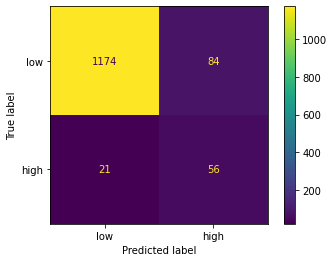

In [182]:
plot_confusion_mx(test_label, test_pred)

### Gaussain Naive Bayes

Gaussain Naive Bayes using the oversampled dataset.

**Define the model**

In [183]:
gnb_model = GaussianNB()

**Train the Gaussain Naive Bayes classifier**

In [184]:
gnb_model.fit(training, labels)
gnb_models['GNB_ov'] = gnb_model

In [185]:
test_pred = gnb_model.predict(test_set)
print(classification_report(test_label, test_pred, target_names = ['low','high']))

              precision    recall  f1-score   support

         low       1.00      0.92      0.95      1258
        high       0.41      0.94      0.57        77

    accuracy                           0.92      1335
   macro avg       0.70      0.93      0.76      1335
weighted avg       0.96      0.92      0.93      1335



The performance report reveals the low capacity of the GNB classifier to correctly classify the hig rank players. This is due to the highly imbalanced dataset.

Let's plot the confusion matrix

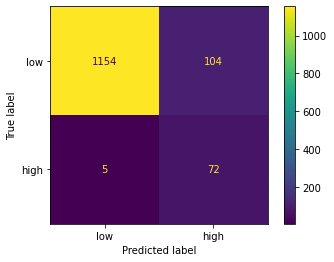

In [186]:
plot_confusion_mx(test_label,test_pred)
plt.show() 

### Neural Networks

In [187]:
norm_ov_train_set = normalize_dataset(training)

In [188]:
nn_model_ov = base_nn_model()
nn_model_ov, history = train_nn_model(nn_model_ov, norm_ov_train_set, labels)
nn_models['NN_smote'] = nn_model_ov

In [189]:
nn_model_ov.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 15)                0         
                                                                 
 dense_6 (Dense)             (None, 15)                240       
                                                                 
 dropout_4 (Dropout)         (None, 15)                0         
                                                                 
 dense_7 (Dense)             (None, 15)                240       
                                                                 
 dropout_5 (Dropout)         (None, 15)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 16        
                                                                 
Total params: 496
Trainable params: 496
Non-trainable 

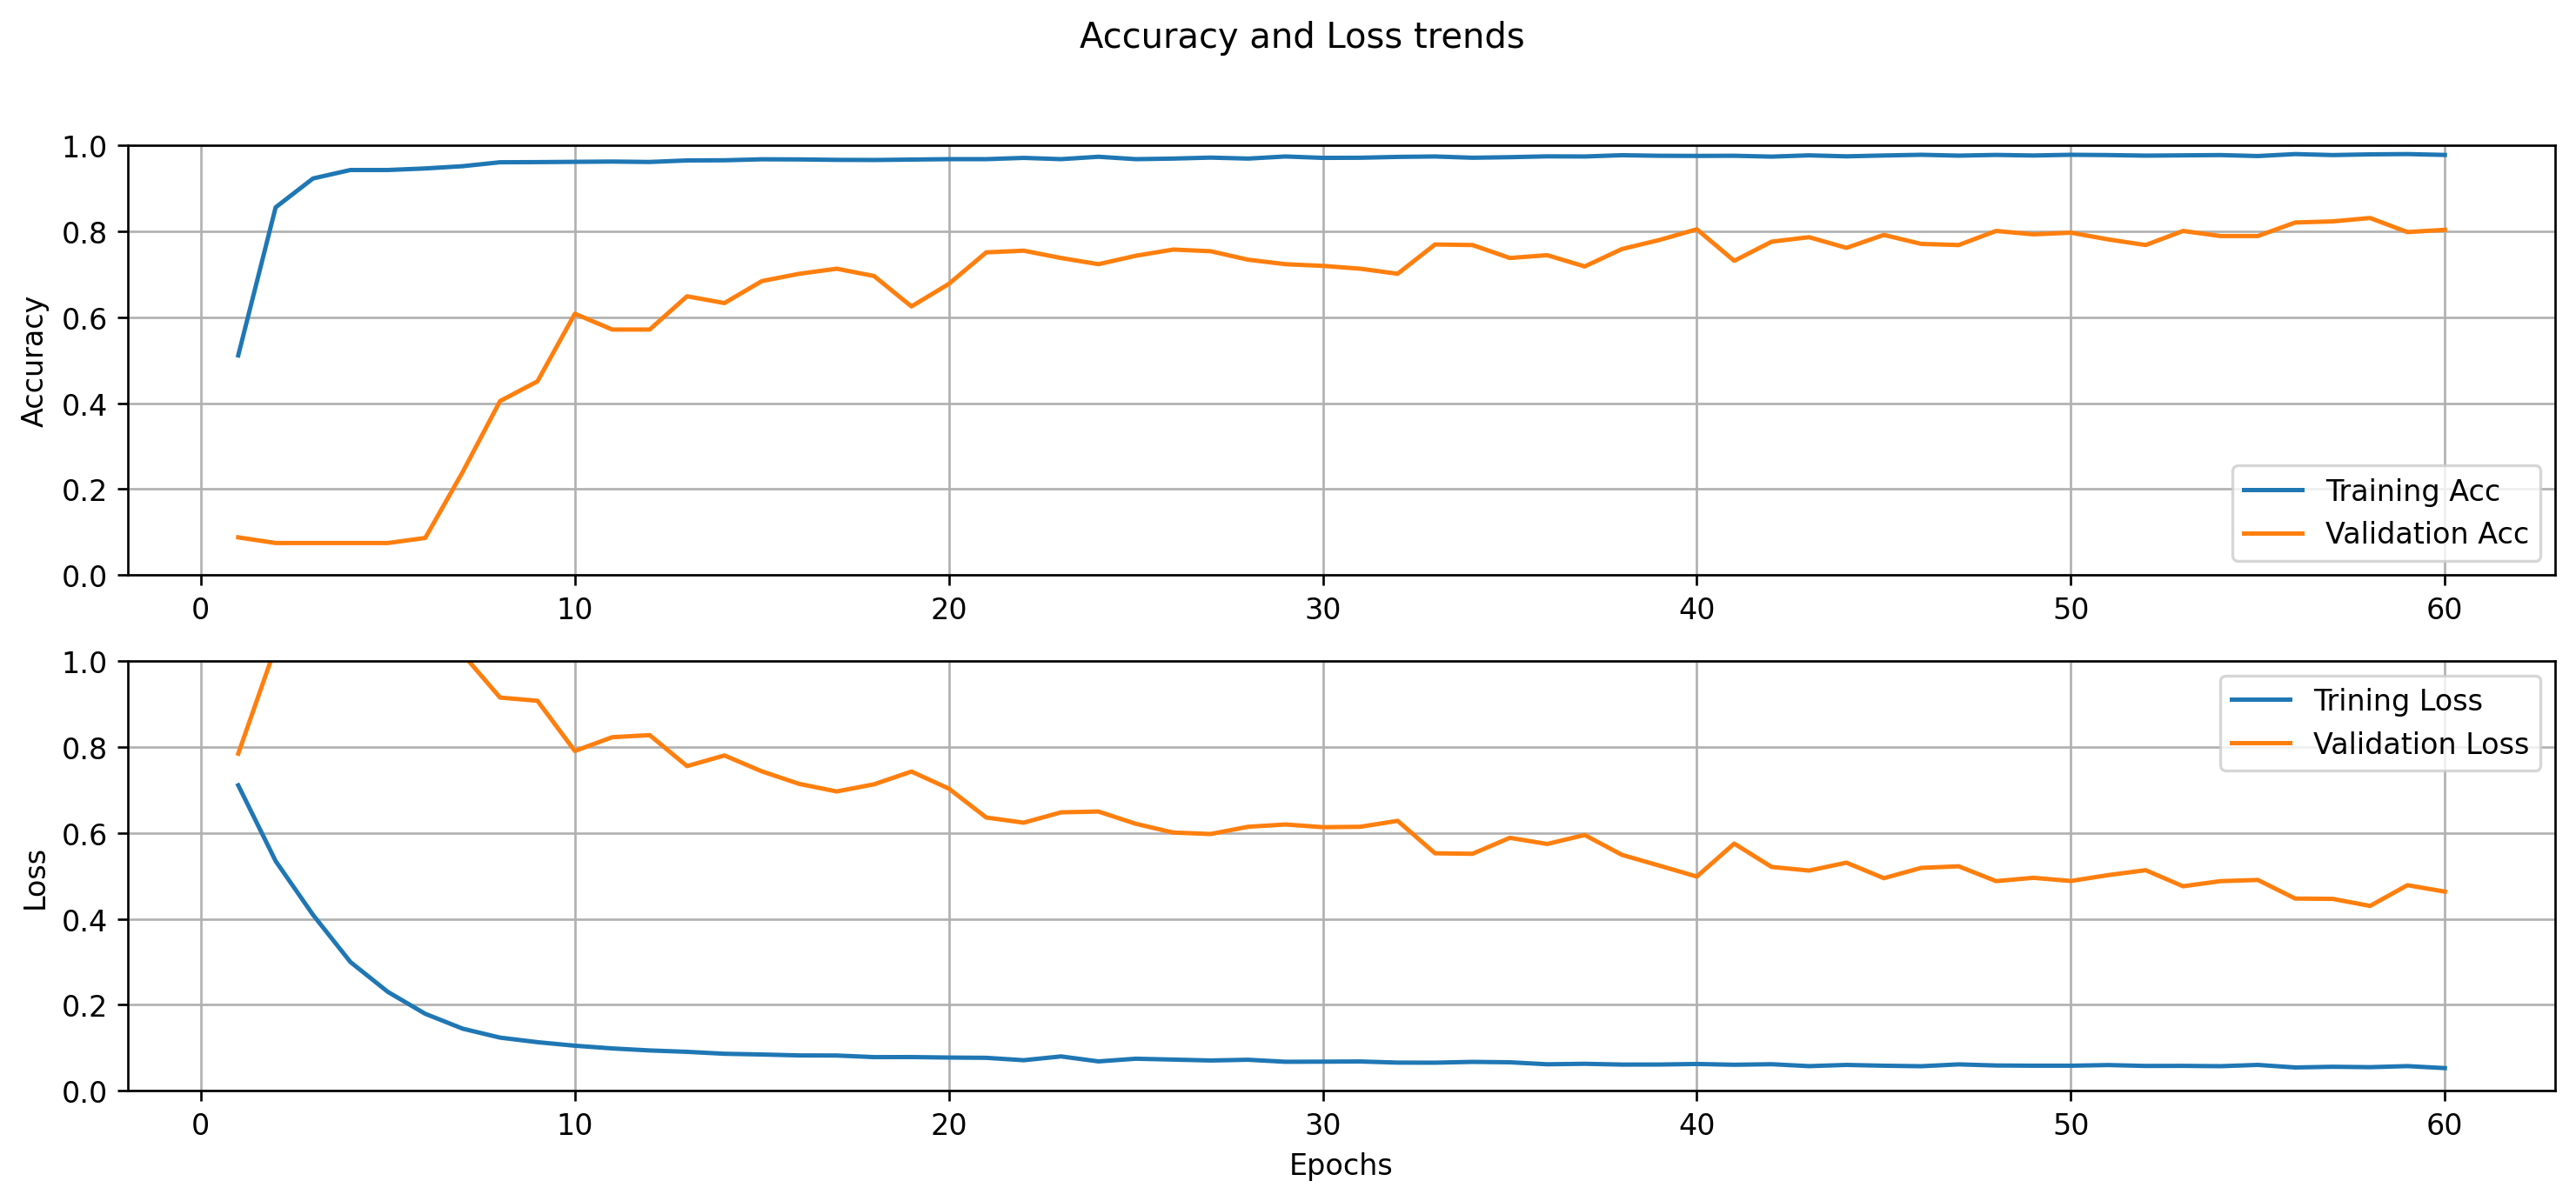

In [190]:
plot_nn_training_history(history)

In [191]:
x_test = np.reshape(norm_test_set.values, (len(norm_test_set), 1, len(norm_test_set.columns)))
test_pred = (nn_model_ov.predict(x_test) > 0.5).astype("int32")

In [192]:
report_scores(test_label, test_pred)

              precision    recall  f1-score   support

         low       0.99      1.00      0.99      1258
        high       0.95      0.78      0.86        77

    accuracy                           0.99      1335
   macro avg       0.97      0.89      0.92      1335
weighted avg       0.98      0.99      0.98      1335



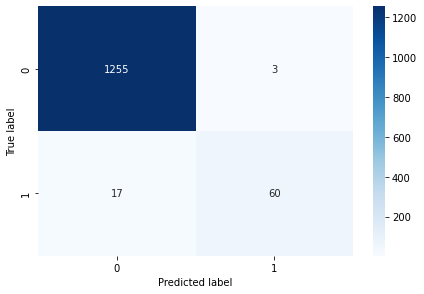

In [193]:
cm=confusion_matrix(test_label,test_pred)
#il parametro fmt serve per evitare la notazione esponenziale dei numeri
sns.heatmap(cm, annot=True,cmap=plt.cm.Blues, fmt='g')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

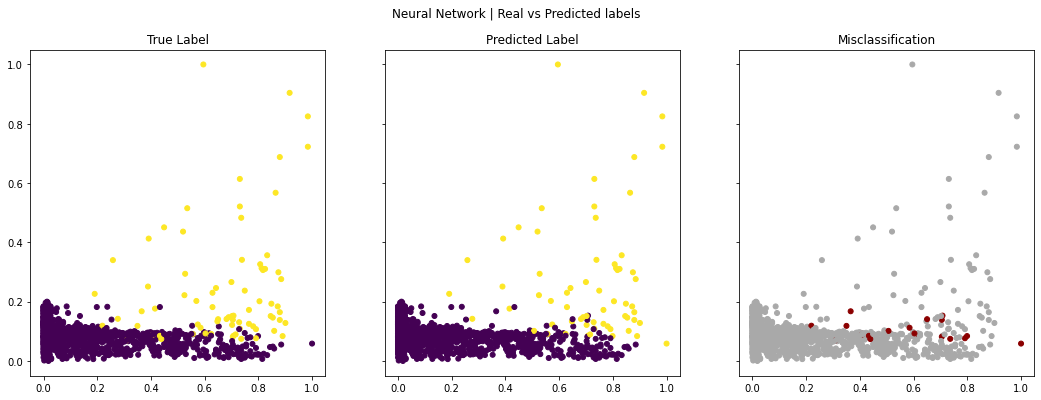

In [194]:
scatter_pred_data(test_set, test_label, test_pred, 'Neural Network', 'nmatch', 'best_rank_points')

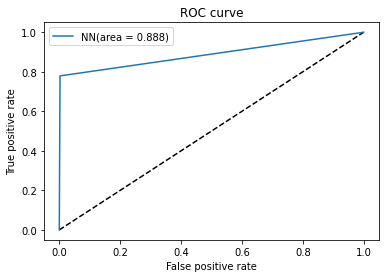

In [195]:
roc_curve_plot(nn_model_ov, norm_test_set, test_label, test_pred, 'NN')

### KNN (K-Nearest Neighbors)

Let's test the KNN on oversampled dataset.

For the KNN we need to remove the categorical attributes.

In [196]:
knn_ov_train_set = training.drop(columns=['sex_num', 'hand_num'])

In [197]:
k_range = range(1,31)

In [198]:
knn_metrics = ['euclidean', 'manhattan']

In [199]:
knn_weights = ['uniform', 'distance']

In [200]:
knn_algorithms = ['ball_tree', 'kd_tree', 'brute']

In [201]:
knn_param_grid = {
    'n_neighbors': k_range,
    'metric': knn_metrics,
    'algorithm': knn_algorithms,
    'weights': knn_weights
            }

In [202]:
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=10, scoring='accuracy')
knn_grid.fit(knn_ov_train_set, labels)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': range(1, 31),
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [203]:
print('Accuracy: ' + str(knn_grid.best_score_))
print('Parameters: ' + str(knn_grid.best_params_))

Accuracy: 0.9840073655714502
Parameters: {'algorithm': 'ball_tree', 'metric': 'manhattan', 'n_neighbors': 2, 'weights': 'uniform'}


In [204]:
knn = KNeighborsClassifier(**knn_grid.best_params_).fit(knn_ov_train_set, labels)
knn_models['knn_ov'] = knn

In [205]:
train_pred = knn.predict(knn_ov_train_set)
report_scores(labels,train_pred)

              precision    recall  f1-score   support

         low       1.00      1.00      1.00      2934
        high       1.00      0.99      0.99       880

    accuracy                           1.00      3814
   macro avg       1.00      0.99      1.00      3814
weighted avg       1.00      1.00      1.00      3814



In [206]:
test_pred = knn.predict(knn_test_set)
report_scores(test_label,test_pred)

              precision    recall  f1-score   support

         low       0.98      0.99      0.98      1258
        high       0.76      0.66      0.71        77

    accuracy                           0.97      1335
   macro avg       0.87      0.82      0.85      1335
weighted avg       0.97      0.97      0.97      1335



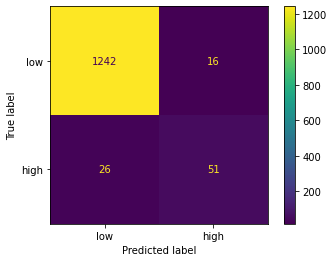

In [207]:
plot_confusion_mx(test_label, test_pred)

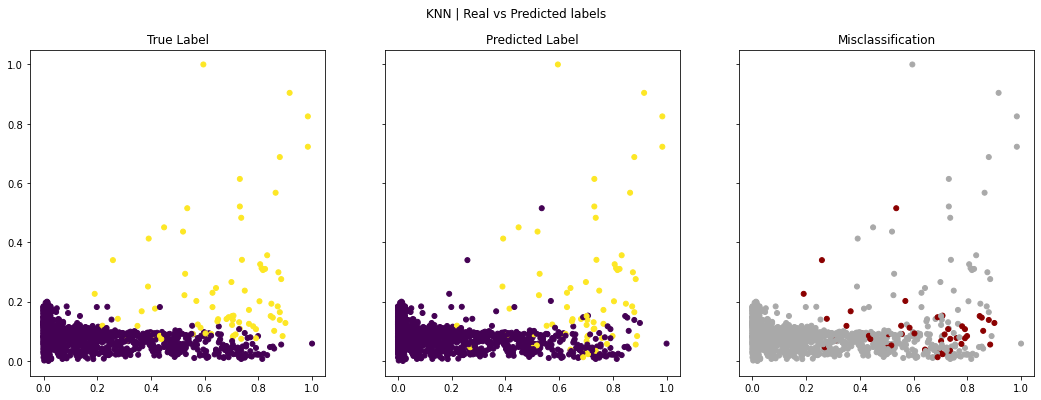

In [208]:
scatter_pred_data(knn_test_set, test_label, test_pred, 'KNN','nmatch', 'best_rank_points')

Train KNN model with normalized oversample dataset.

In [209]:
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=10, scoring='accuracy')
norm_knn_train_set = normalize_dataset(knn_ov_train_set)
norm_knn_test_set = normalize_dataset(knn_test_set)
knn_grid.fit(norm_knn_train_set, labels)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': range(1, 31),
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [210]:
print('Accuracy: ' + str(knn_grid.best_score_))
print('Parameters: ' + str(knn_grid.best_params_))

Accuracy: 0.9840073655714502
Parameters: {'algorithm': 'ball_tree', 'metric': 'manhattan', 'n_neighbors': 2, 'weights': 'uniform'}


In [211]:
knn = KNeighborsClassifier(**knn_grid.best_params_).fit(norm_knn_train_set, labels)

In [212]:
train_pred = knn.predict(norm_knn_train_set)
report_scores(labels,train_pred)

              precision    recall  f1-score   support

         low       1.00      1.00      1.00      2934
        high       1.00      0.99      0.99       880

    accuracy                           1.00      3814
   macro avg       1.00      0.99      1.00      3814
weighted avg       1.00      1.00      1.00      3814



In [213]:
test_pred = knn.predict(norm_knn_test_set)
report_scores(test_label,test_pred)

              precision    recall  f1-score   support

         low       0.98      0.99      0.98      1258
        high       0.76      0.66      0.71        77

    accuracy                           0.97      1335
   macro avg       0.87      0.82      0.85      1335
weighted avg       0.97      0.97      0.97      1335



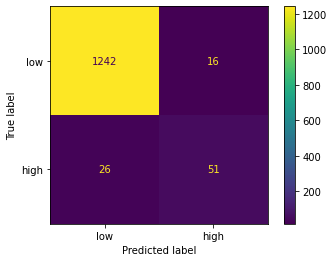

In [214]:
plot_confusion_mx(test_label, test_pred)

# Sumup Classifiers Comparison

In this section, the performances of all the analyzed classifiers are compared on the three datasets.

### Decision tree versions comparision

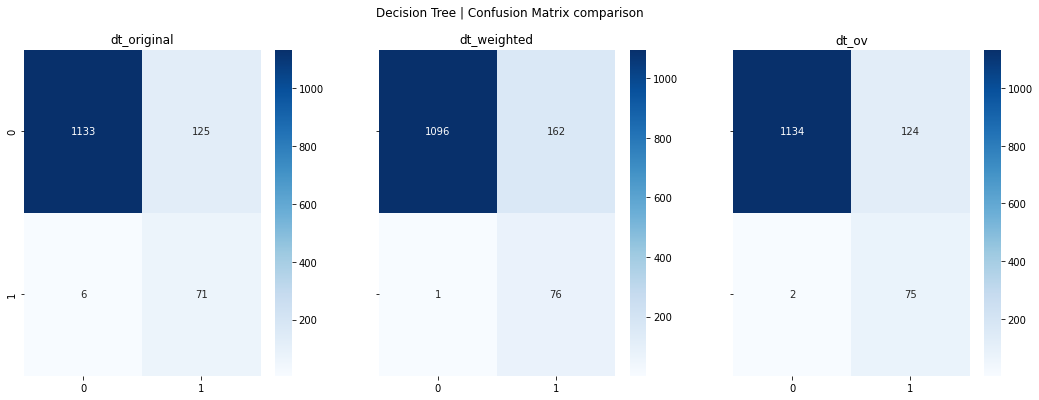

In [215]:
compare_models(dt_models, 'Decision Tree', test_set, test_label)

In [216]:
print('\t\t\t TRAINING SCORES')
compare_scores(dt_models,train_set, train_label)

			 TRAINING SCORES
			dt_original
              precision    recall  f1-score   support

         low       0.99      0.99      0.99      2934
        high       0.92      0.92      0.92       178

    accuracy                           0.99      3112
   macro avg       0.96      0.96      0.96      3112
weighted avg       0.99      0.99      0.99      3112

			dt_weighted
              precision    recall  f1-score   support

         low       1.00      0.98      0.99      2934
        high       0.73      1.00      0.84       178

    accuracy                           0.98      3112
   macro avg       0.86      0.99      0.92      3112
weighted avg       0.98      0.98      0.98      3112

			dt_ov
              precision    recall  f1-score   support

         low       1.00      0.99      1.00      2934
        high       0.89      0.97      0.93       178

    accuracy                           0.99      3112
   macro avg       0.94      0.98      0.96      3112
weighted avg   

In [217]:
print('\t\t\t TEST SCORES')
compare_scores(dt_models,test_set, test_label)

			 TEST SCORES
			dt_original
              precision    recall  f1-score   support

         low       0.99      0.90      0.95      1258
        high       0.36      0.92      0.52        77

    accuracy                           0.90      1335
   macro avg       0.68      0.91      0.73      1335
weighted avg       0.96      0.90      0.92      1335

			dt_weighted
              precision    recall  f1-score   support

         low       1.00      0.87      0.93      1258
        high       0.32      0.99      0.48        77

    accuracy                           0.88      1335
   macro avg       0.66      0.93      0.71      1335
weighted avg       0.96      0.88      0.90      1335

			dt_ov
              precision    recall  f1-score   support

         low       1.00      0.90      0.95      1258
        high       0.38      0.97      0.54        77

    accuracy                           0.91      1335
   macro avg       0.69      0.94      0.75      1335
weighted avg       

### SVM versions comparision

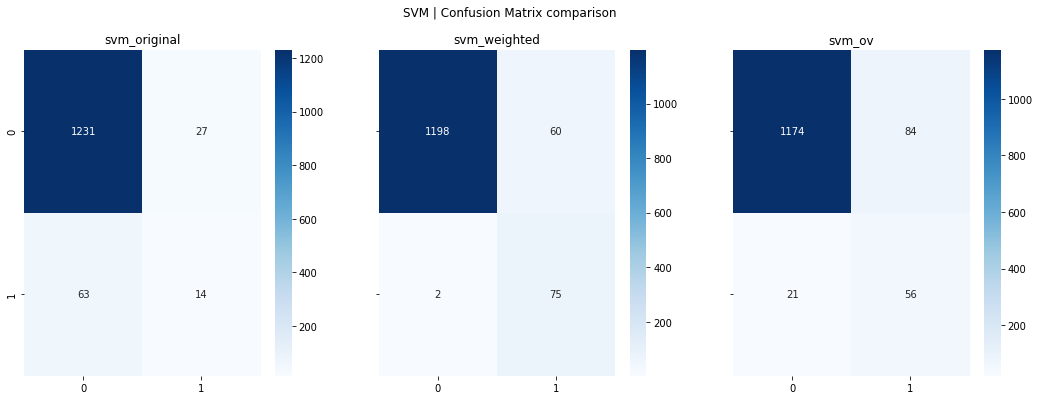

In [218]:
compare_models(svm_models, 'SVM', test_set, test_label)

In [219]:
print('\t\t\t TRAINING SCORES')
compare_scores(svm_models,train_set, train_label)

			 TRAINING SCORES
			svm_original
              precision    recall  f1-score   support

         low       0.96      0.98      0.97      2934
        high       0.46      0.29      0.36       178

    accuracy                           0.94      3112
   macro avg       0.71      0.64      0.66      3112
weighted avg       0.93      0.94      0.93      3112

			svm_weighted
              precision    recall  f1-score   support

         low       1.00      0.95      0.97      2934
        high       0.54      0.98      0.69       178

    accuracy                           0.95      3112
   macro avg       0.77      0.96      0.83      3112
weighted avg       0.97      0.95      0.96      3112

			svm_ov
              precision    recall  f1-score   support

         low       0.99      0.93      0.96      2934
        high       0.39      0.78      0.52       178

    accuracy                           0.92      3112
   macro avg       0.69      0.85      0.74      3112
weighted avg

In [220]:
print('\t\t\t TEST SCORES')
compare_scores(svm_models,test_set, test_label)

			 TEST SCORES
			svm_original
              precision    recall  f1-score   support

         low       0.95      0.98      0.96      1258
        high       0.34      0.18      0.24        77

    accuracy                           0.93      1335
   macro avg       0.65      0.58      0.60      1335
weighted avg       0.92      0.93      0.92      1335

			svm_weighted
              precision    recall  f1-score   support

         low       1.00      0.95      0.97      1258
        high       0.56      0.97      0.71        77

    accuracy                           0.95      1335
   macro avg       0.78      0.96      0.84      1335
weighted avg       0.97      0.95      0.96      1335

			svm_ov
              precision    recall  f1-score   support

         low       0.98      0.93      0.96      1258
        high       0.40      0.73      0.52        77

    accuracy                           0.92      1335
   macro avg       0.69      0.83      0.74      1335
weighted avg    

### Rule based versions comparision

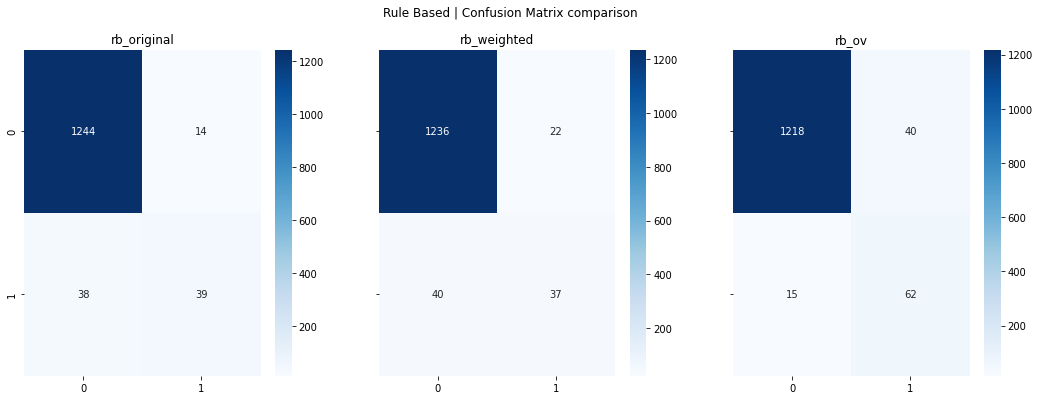

In [221]:
compare_models(rb_models, 'Rule Based', test_set, test_label)

In [222]:
print('\t\t\t TRAINING SCORES')
compare_scores(rb_models,train_set, train_label)

			 TRAINING SCORES
			rb_original
              precision    recall  f1-score   support

         low       0.97      1.00      0.98      2934
        high       0.90      0.56      0.69       178

    accuracy                           0.97      3112
   macro avg       0.94      0.78      0.84      3112
weighted avg       0.97      0.97      0.97      3112

			rb_weighted
              precision    recall  f1-score   support

         low       0.98      0.99      0.98      2934
        high       0.82      0.61      0.70       178

    accuracy                           0.97      3112
   macro avg       0.90      0.80      0.84      3112
weighted avg       0.97      0.97      0.97      3112

			rb_ov
              precision    recall  f1-score   support

         low       1.00      0.98      0.99      2934
        high       0.77      0.98      0.86       178

    accuracy                           0.98      3112
   macro avg       0.88      0.98      0.93      3112
weighted avg   

In [223]:
print('\t\t\t TEST SCORES')
compare_scores(rb_models,test_set, test_label)

			 TEST SCORES
			rb_original
              precision    recall  f1-score   support

         low       0.97      0.99      0.98      1258
        high       0.74      0.51      0.60        77

    accuracy                           0.96      1335
   macro avg       0.85      0.75      0.79      1335
weighted avg       0.96      0.96      0.96      1335

			rb_weighted
              precision    recall  f1-score   support

         low       0.97      0.98      0.98      1258
        high       0.63      0.48      0.54        77

    accuracy                           0.95      1335
   macro avg       0.80      0.73      0.76      1335
weighted avg       0.95      0.95      0.95      1335

			rb_ov
              precision    recall  f1-score   support

         low       0.99      0.97      0.98      1258
        high       0.61      0.81      0.69        77

    accuracy                           0.96      1335
   macro avg       0.80      0.89      0.84      1335
weighted avg       

### Gaussain Naive Bayes versions comparision

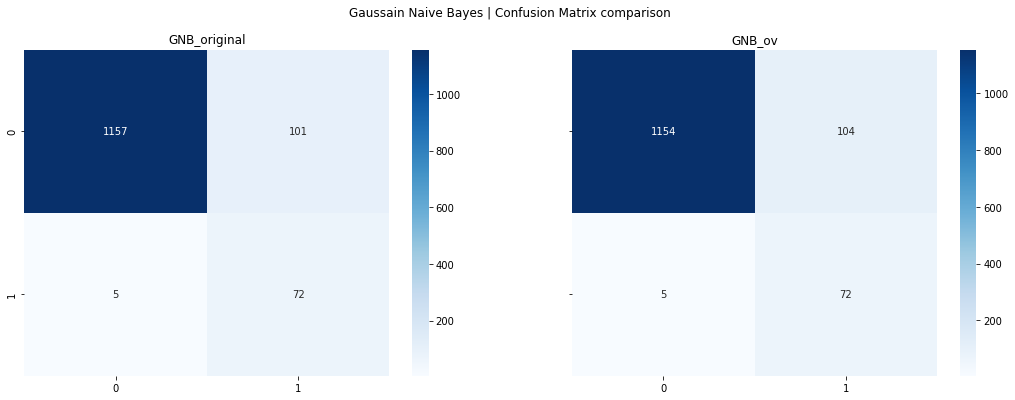

In [224]:
compare_models(gnb_models, 'Gaussain Naive Bayes', test_set, test_label)

In [225]:
print('\t\t\t TRAINING SCORES')
compare_scores(gnb_models,train_set, train_label)

			 TRAINING SCORES
			GNB_original
              precision    recall  f1-score   support

         low       1.00      0.93      0.96      2934
        high       0.44      0.94      0.60       178

    accuracy                           0.93      3112
   macro avg       0.72      0.94      0.78      3112
weighted avg       0.96      0.93      0.94      3112

			GNB_ov
              precision    recall  f1-score   support

         low       1.00      0.92      0.96      2934
        high       0.43      0.94      0.59       178

    accuracy                           0.92      3112
   macro avg       0.71      0.93      0.77      3112
weighted avg       0.96      0.92      0.94      3112



In [226]:
print('\t\t\t TEST SCORES')
compare_scores(gnb_models,test_set, test_label)

			 TEST SCORES
			GNB_original
              precision    recall  f1-score   support

         low       1.00      0.92      0.96      1258
        high       0.42      0.94      0.58        77

    accuracy                           0.92      1335
   macro avg       0.71      0.93      0.77      1335
weighted avg       0.96      0.92      0.93      1335

			GNB_ov
              precision    recall  f1-score   support

         low       1.00      0.92      0.95      1258
        high       0.41      0.94      0.57        77

    accuracy                           0.92      1335
   macro avg       0.70      0.93      0.76      1335
weighted avg       0.96      0.92      0.93      1335



### Neural Network versions comparision

In [227]:
def compare_nn_models(models_list, classifier_name, test_set, test_label):
    i = 0
    col_count = len(train_set.columns)
    fig, axs = plt.subplots(nrows=1,ncols=len(models_list), figsize=(18,6), sharey=True)
    title = classifier_name + ' | Confusion Matrix comparison'
    plt.suptitle(title)
    for model in models_list.keys():
        x_test = np.reshape(test_set.values, (len(test_set), 1, col_count))
        test_pred = (models_list[model].predict(x_test) > 0.5).astype("int32")
        cm=confusion_matrix(test_label,test_pred)
        sns.heatmap(cm, ax=axs[i], annot=True,cmap=plt.cm.Blues, fmt='g')
        axs[i].set_title(model)
        i+=1

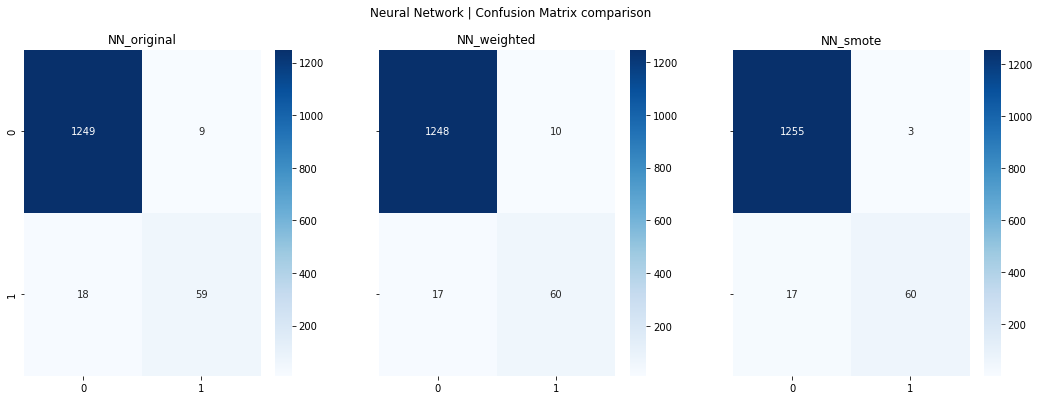

In [228]:
compare_nn_models(nn_models, 'Neural Network',norm_test_set, test_label)

### KNN versions comparision

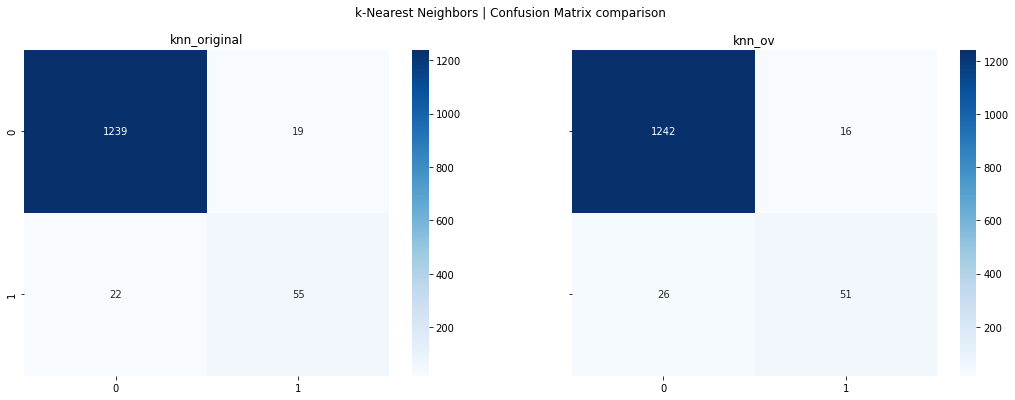

In [229]:
compare_models(knn_models, 'k-Nearest Neighbors', knn_test_set, test_label)

In [230]:
print('\t\t\t TRAINING SCORES')
compare_scores(knn_models,knn_train_set, train_label)

			 TRAINING SCORES
			knn_original
              precision    recall  f1-score   support

         low       0.99      1.00      0.99      2934
        high       0.95      0.83      0.88       178

    accuracy                           0.99      3112
   macro avg       0.97      0.91      0.94      3112
weighted avg       0.99      0.99      0.99      3112

			knn_ov
              precision    recall  f1-score   support

         low       1.00      1.00      1.00      2934
        high       1.00      0.98      0.99       178

    accuracy                           1.00      3112
   macro avg       1.00      0.99      0.99      3112
weighted avg       1.00      1.00      1.00      3112



In [231]:
print('\t\t\t TEST SCORES')
compare_scores(knn_models,knn_test_set, test_label)

			 TEST SCORES
			knn_original
              precision    recall  f1-score   support

         low       0.98      0.98      0.98      1258
        high       0.74      0.71      0.73        77

    accuracy                           0.97      1335
   macro avg       0.86      0.85      0.86      1335
weighted avg       0.97      0.97      0.97      1335

			knn_ov
              precision    recall  f1-score   support

         low       0.98      0.99      0.98      1258
        high       0.76      0.66      0.71        77

    accuracy                           0.97      1335
   macro avg       0.87      0.82      0.85      1335
weighted avg       0.97      0.97      0.97      1335

